# Interactive Play

Idea: define and play high-level moves and show the results before and after with some kind of rendering

In [1]:
import sys
sys.path.insert(0, "../")
import copy
import matplotlib.pyplot as plt
import numpy as np
from SC_Utils.game_utils import init_game, ObsProcesser
from SC_Utils.render import *
from SC_Utils.train_v2 import merge_screen_and_minimap
from Utils import test_SCEnv_motion as actions
from pysc2.lib import actions as sc_actions
import math

from IPython.display import clear_output

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class InteractivePlay():
    def __init__(self, map_name, screen_res, minimap_res, **kwargs):
        self.screen_res = screen_res
        self.minimap_res = minimap_res
        self.current_state = None
        self.last_state = None
        game_params = dict(feature_screen=screen_res, feature_minimap=minimap_res, action_space="FEATURES") 
        self.env = init_game(game_params, map_name=map_name, max_steps=256, random_seed=1)
        self.obs_proc = ObsProcesser(**kwargs)
        
    def reset(self, show_available=True):
        obs = self.env.reset()
        if show_available:
            print("Available actions: ")
            for a in obs[0].observation.available_actions:
                print(sc_actions.FUNCTIONS[a])
        self.print_player_info(obs)
        state, names = self.obs_proc.get_state(obs)
        state = merge_screen_and_minimap(state)
        self.current_state = state
        self.print_unit_positions(names)
        self.render(names)
        return
    
    def step(self, action, show_available=False, player_info=True):
        self.last_state = copy.deepcopy(self.current_state)
        print("Action taken: ", action[0])
        obs = self.env.step(actions=action)
        reward = obs[0].reward
        print("Reward: ", reward)
        if show_available:
            #print("Control groups: ", obs[0].observation.control_groups)
            print("Available actions: ")
            for a in obs[0].observation.available_actions:
                print(sc_actions.FUNCTIONS[a])
        if player_info:
            self.print_player_info(obs)
        state, names = self.obs_proc.get_state(obs)
        state = merge_screen_and_minimap(state)
        self.current_state = state
        return names
    
    def render(self, names, screen_only=False, n_cols=5):
        if screen_only:
            self.render_screen(names)
        else:
            fig = plt.figure(figsize=(14,6))
            plt.subplot(121)
            self.render_screen(names)
            plt.subplot(122)
            self.render_minimap(names)
        plt.show()
        
        n_screen_layers = len(names['screen_names'])
        plt.figure(figsize=(3*n_cols, 3*math.ceil(n_screen_layers/n_cols)))
        plot_screen_layers_grid(self.current_state, names, n_cols)
        plt.show()
        
        n_minimap_layers = len(names['minimap_names'])
        plt.figure(figsize=(3*n_cols, 3*math.ceil(n_minimap_layers/n_cols)))
        plot_minimap_layers_grid(self.current_state, names, n_cols)
        plt.show()
        
        return
    
    def render_screen(self, names):
        plot_screen(self.current_state, names, self.last_state)
        return
    
    def render_minimap(self, names):
        plot_minimap(self.current_state, names, self.last_state)
        return
    
    def print_player_info(self, obs):
        print("\nPlayer info: ")
        player_obs = obs[0].observation['player']
        for k in player_obs._index_names[0].keys():
            print(k+": ", player_obs[k])
        
    def interactive_step(self, action, show_available=False, rendering=True):
        # print action taken v
        # print reward received from current step v
        # print player info formatted v
        # print available actions for next step v
        # print rgb rendering of screen and minimap v
        # print ohe screen layers in a grid
        # print ohe minimap layers in a grid
        names = self.step(action, show_available)
        self.print_unit_positions(names) # basically skipped if plot = False
        if rendering:
            self.render(names)
        return
    
    def print_unit_positions(self, names, plot=False):
        if plot:
            screen_names = names['screen_names']
            s = self.current_state[:len(screen_names)]
            if 'player_relative_1' in screen_names:
                friendly_idx = np.where(screen_names == 'player_relative_1')[0]
                neutral_idx = np.where(screen_names == 'player_relative_3')[0]
                enemy_idx = np.where(screen_names == 'player_relative_4')[0]
            else:
                print("No player relative layer available")

            player_ys, player_xs = s[friendly_idx].reshape(s.shape[-2:]).nonzero()
            print("Friendly units positions: ")
            for x, y in zip(player_xs, player_ys):
                print('x,y: ', x,y)
                
            player_ys, player_xs = s[neutral_idx].reshape(s.shape[-2:]).nonzero()
            print("Neutral units positions: ", player_xs, player_ys)
                
            player_ys, player_xs = s[enemy_idx].reshape(s.shape[-2:]).nonzero()
            print("Enemy units positions: ")
            for x, y in zip(player_xs, player_ys):
                print('x,y: ', x,y)
        return
    
    def close(self):
        self.env.close()

In [5]:
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[4]
screen_res, minimap_res = 64, 64
screen_names = ['visibility_map', 'player_relative', 'unit_density','selected']
#preproc_args = dict(screen_names=screen_names)
preproc_args = dict(select_all=True)

In [6]:
choices = ['upper-right',
           'upper-center',
           'upper-left',
           'middle-right',
           'middle-center',
           'middle-left',
           'lower-right',
           'lower-center',
           'lower-left']

RESOLUTION = screen_res
yx_points_dict = { 'upper-right':[0, RESOLUTION-1],
                   'upper-center':[0, RESOLUTION//2],
                   'upper-left':[0,0],
                   'middle-right':[RESOLUTION//2, RESOLUTION-1],
                   'middle-center':[RESOLUTION//2, RESOLUTION//2],
                   'middle-left':[RESOLUTION//2, 0],
                   'lower-right':[RESOLUTION-1,RESOLUTION-1],
                   'lower-center':[RESOLUTION-1,RESOLUTION//2],
                   'lower-left':[RESOLUTION-1, 0] 
                 }

Note: after some experiments it appears that clicking on top of a mineral shard somehow is prohibited (in the sense that the resulting action is null).

# Example - CollectMineralsAndGas

Task description:

A map with 12 SCVs, 1 Command Center, 16 Mineral Fields and 4 Vespene Geysers. Rewards are based on the total amount of Minerals and Vespene Gas collected. Spending Minerals and Vespene Gas to train new units does not decrease your reward tally. Optimal collection will require expanding your capacity to gather Minerals and Vespene Gas by constructing additional SCVs and an additional Command Center.

Notes:
- no combat units -> no select army

New actions (selecting workers):
- 5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
- 6/select_idle_worker (10/select_worker [4])
- 264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
- 549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
- 220/Effect_Repair_screen (3/queued [2]; 0/screen [0, 0])
- 221/Effect_Repair_autocast ()
- 230/Effect_Spray_screen (3/queued [2]; 0/screen [0, 0])

Probably just the first 3 are useful.

New actions (command center):
- 294/LoadAll_quick (3/queued [2])
- 490/Train_SCV_quick (3/queued [2])
- 343/Rally_Workers_screen (3/queued [2]; 0/screen [0, 0])
- 344/Rally_Workers_minimap (3/queued [2]; 1/minimap [0, 0])
- 281/Lift_quick (3/queued [2])

Here the only useful might be Train_SCV_quick.

Other SCVs' actions unlocked after a certain amount of minerals collected 
- 269/Harvest_Return_quick (3/queued [2])
- 79/Build_Refinery_screen (3/queued [2]; 0/screen [0, 0])
- 91/Build_SupplyDepot_screen (3/queued [2]; 0/screen [0, 0])
- 50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
- 44/Build_CommandCenter_screen (3/queued [2]; 0/screen [0, 0])

I think refinery should be the one for collecting gas

In [10]:
#iplay.close()

In [7]:
iplay = InteractivePlay(map_name, screen_res, minimap_res, **preproc_args)

Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
7/select_army (7/select_add [2])

Player info: 
player_id:  1
minerals:  0
vespene:  0
food_used:  3
food_cap:  0
food_army:  3
food_workers:  0
idle_worker_count:  0
army_count:  3
warp_gate_count:  0
larva_count:  0


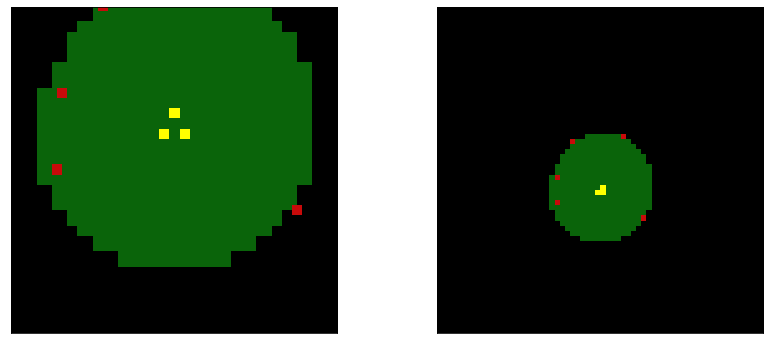

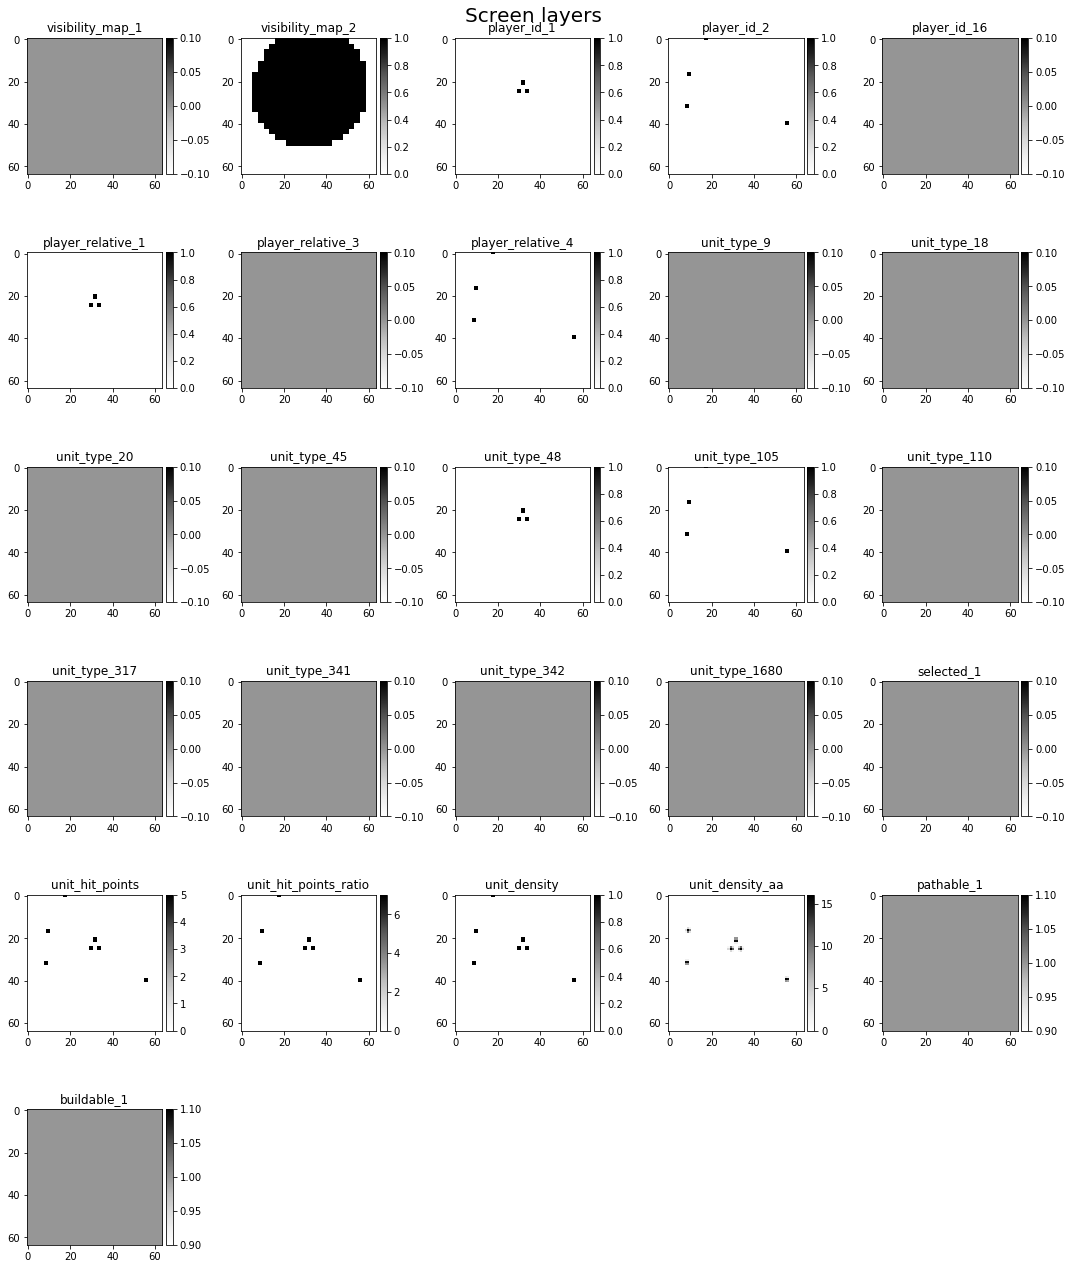

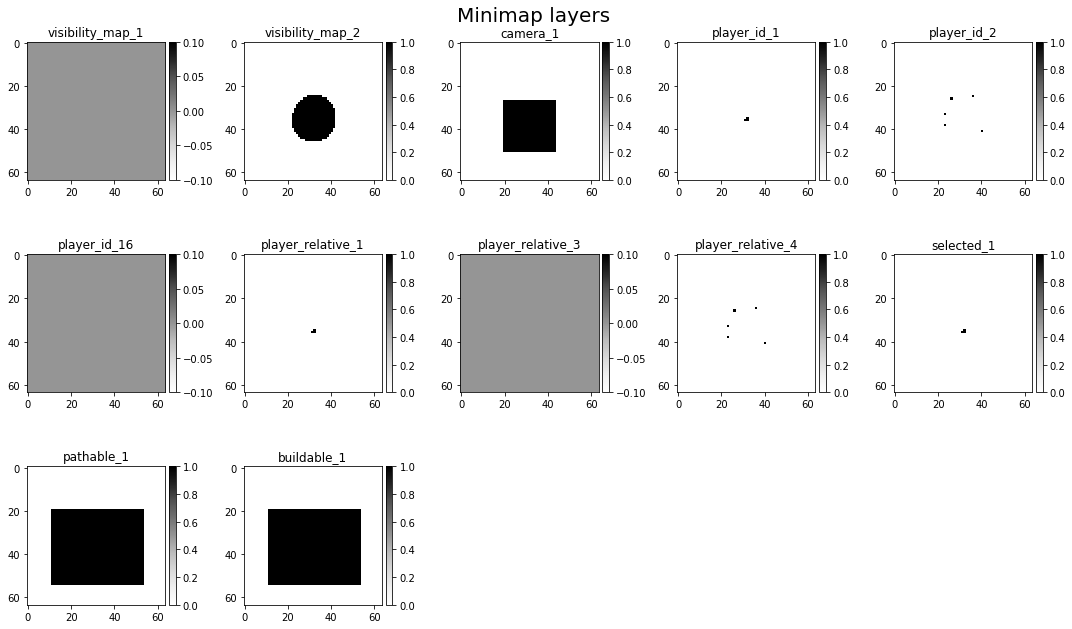

In [8]:
iplay.reset()

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
453/Stop_quick (3/queued [2])
7/select_army (7/select_add [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])

Player info: 
player_id:  1
minerals:  0
vespene:  0
food_used:  3
food_cap:  0
food_army:  3
food_workers: 

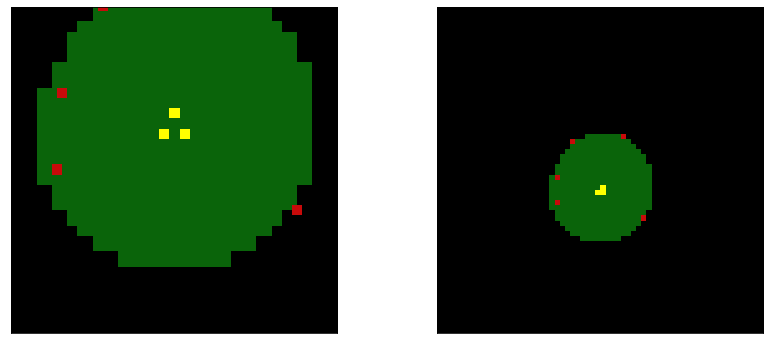

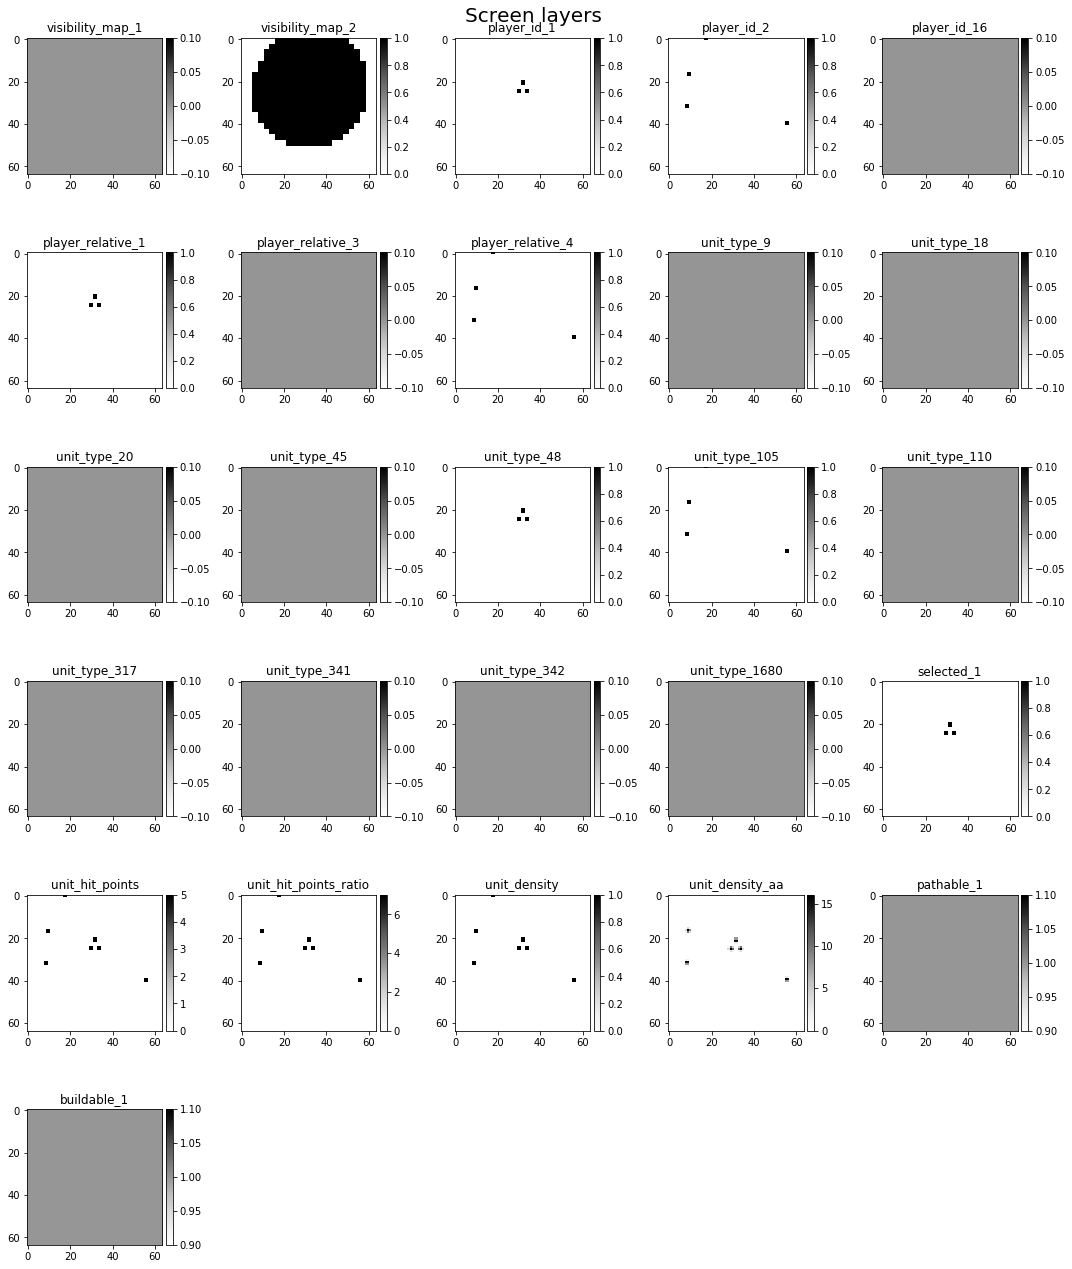

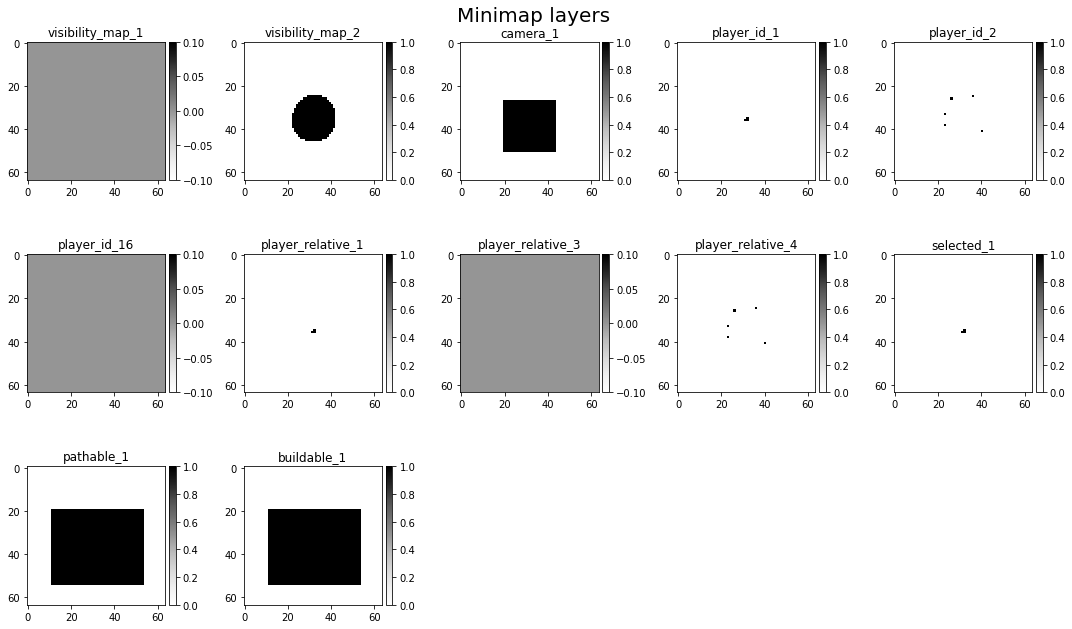

In [9]:
# 0/no_op()
a_id = 0
a_args = []
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=3, arguments=[[0], [10, 20], [25, 50]])
Reward:  0

Player info: 
player_id:  1
minerals:  50
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  12
army_count:  0
warp_gate_count:  0
larva_count:  0


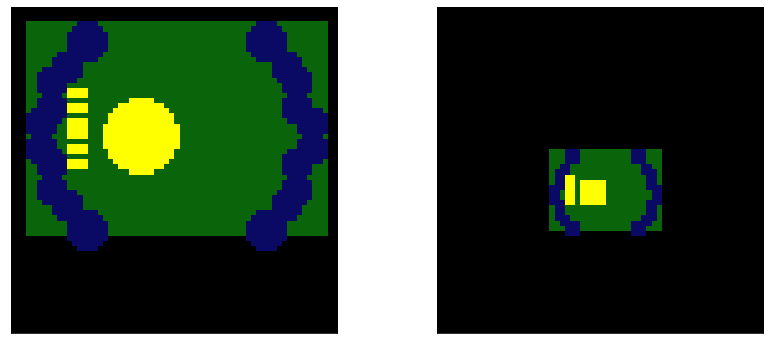

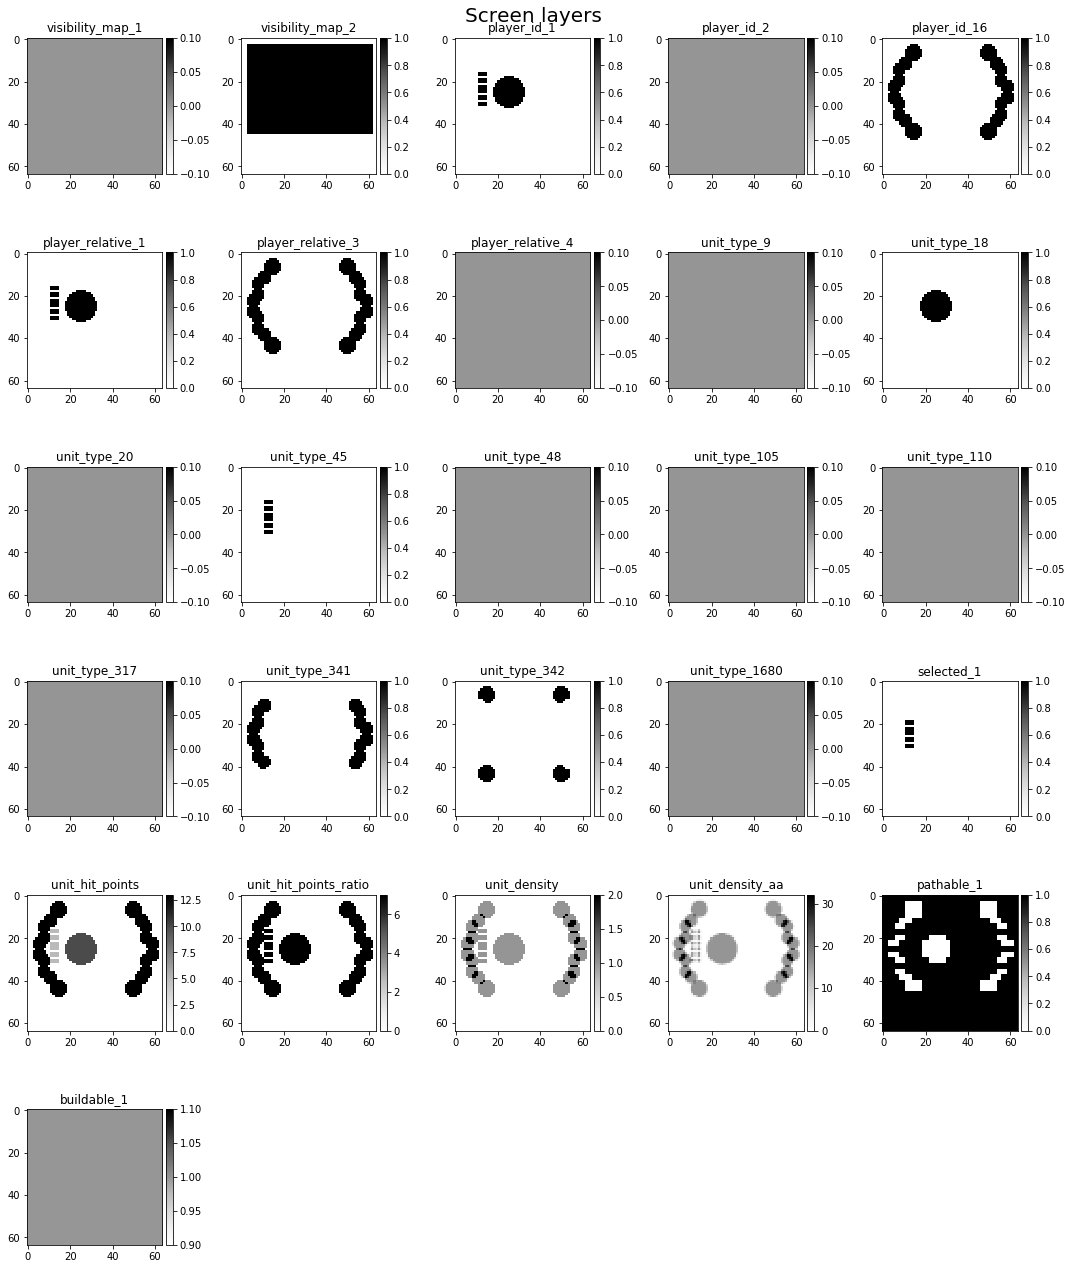

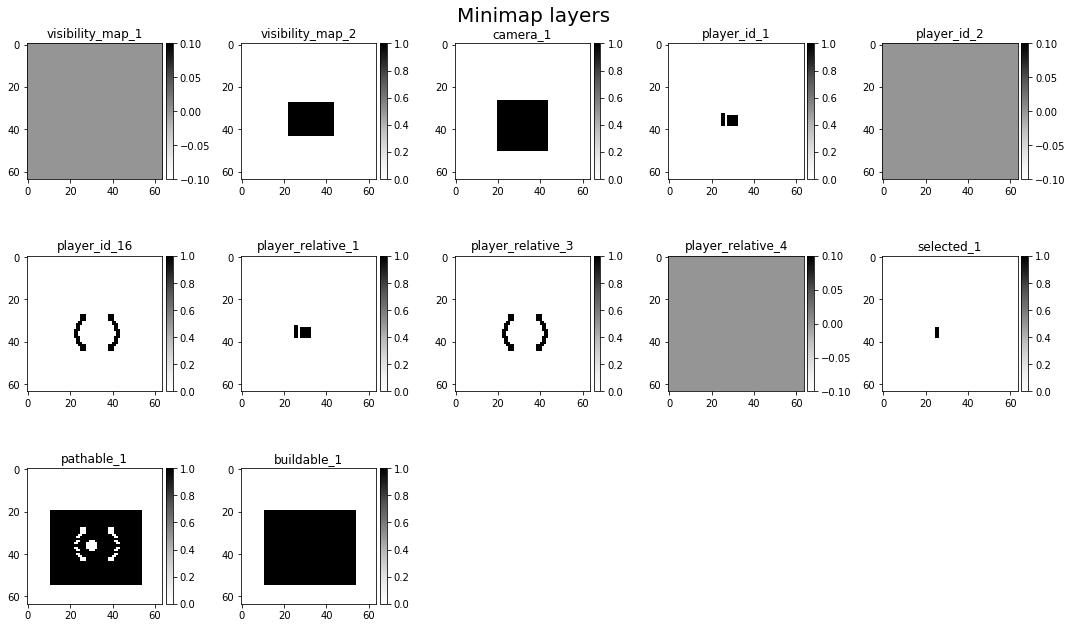

In [9]:
# Select SCVs
# select rectangle: 3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
a_id = 3
a_args = [[0], [10,20],[25,50]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=264, arguments=[[0], [6, 30]])
Reward:  0

Player info: 
player_id:  1
minerals:  50
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


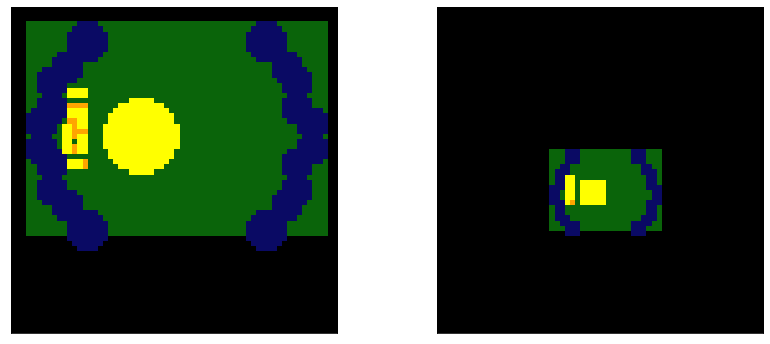

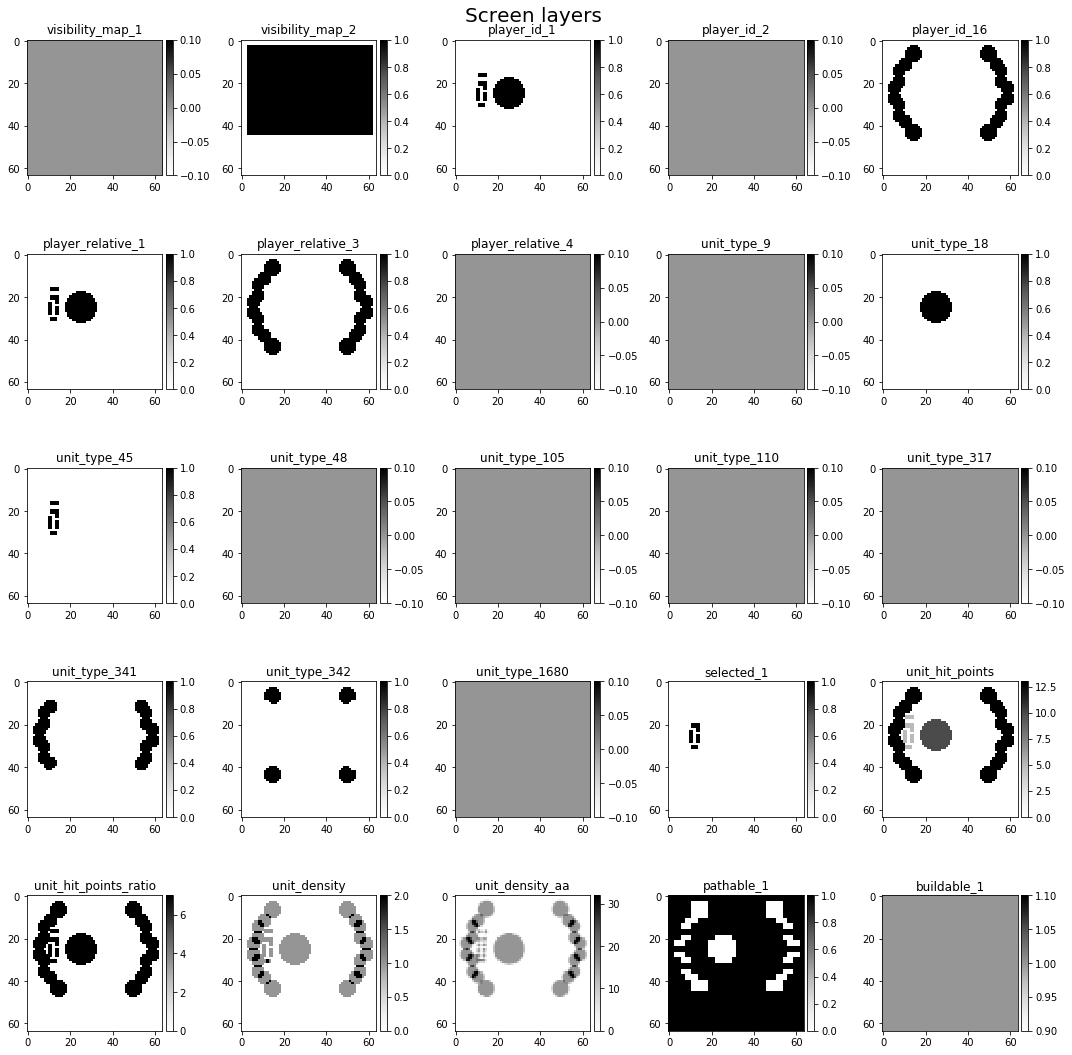

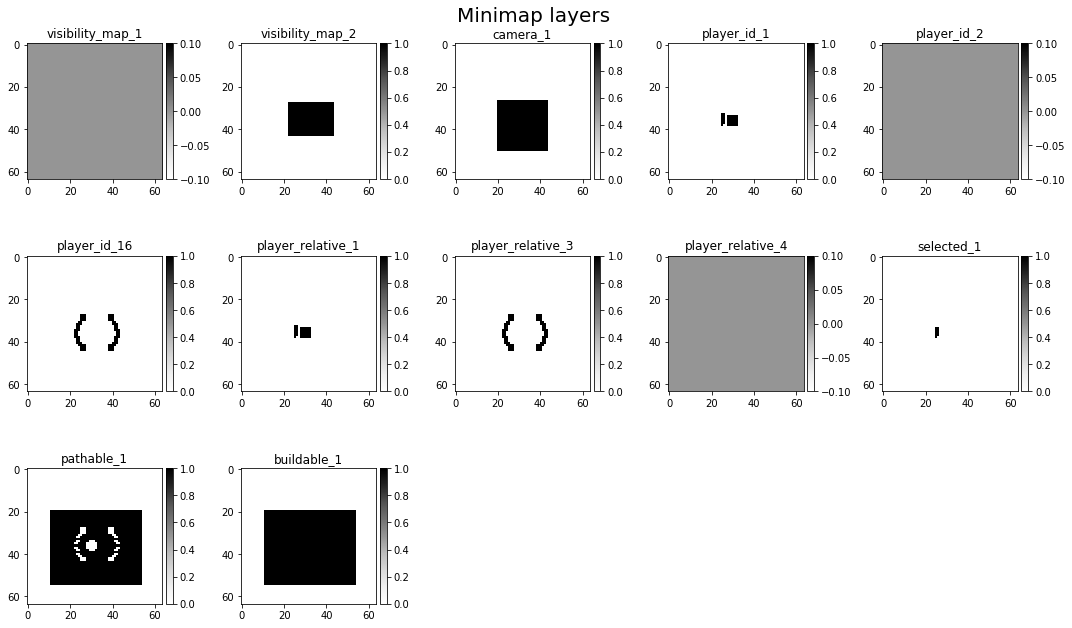

In [16]:
# 264/Harvest_Gather_screen and click on minerals
for i in range(1):
    clear_output(wait=True)
    a_id = 264
    a_args = [[0],[6,30]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  0

Player info: 
player_id:  1
minerals:  175
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


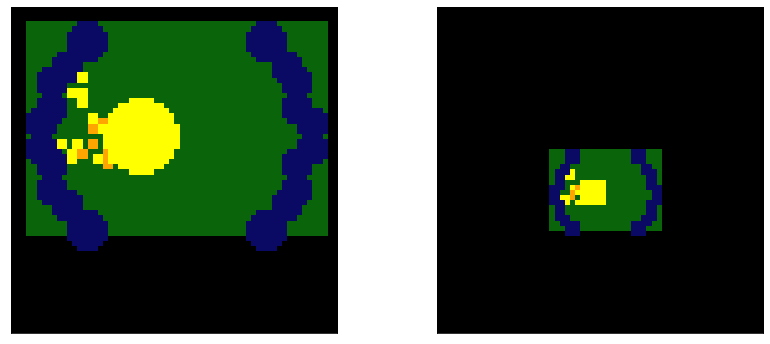

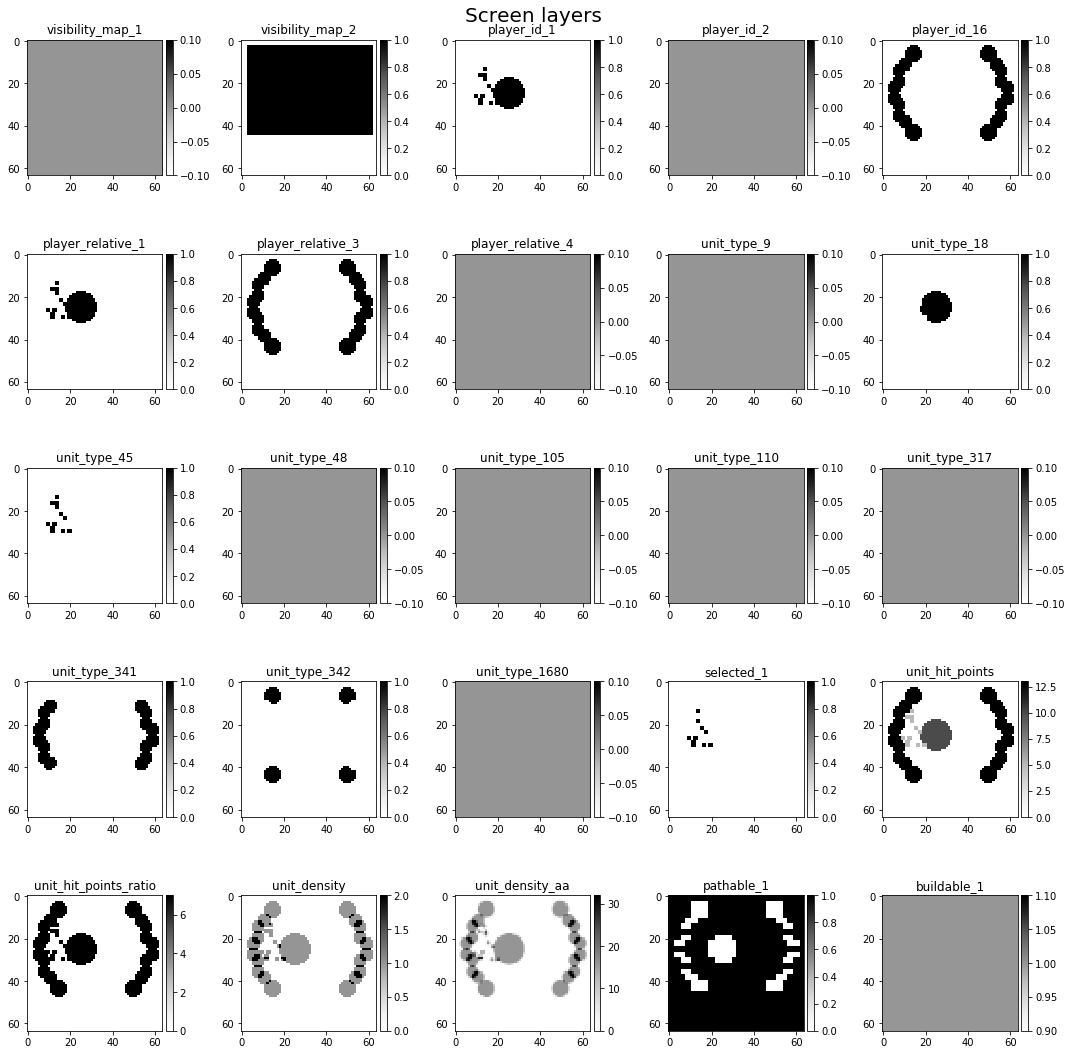

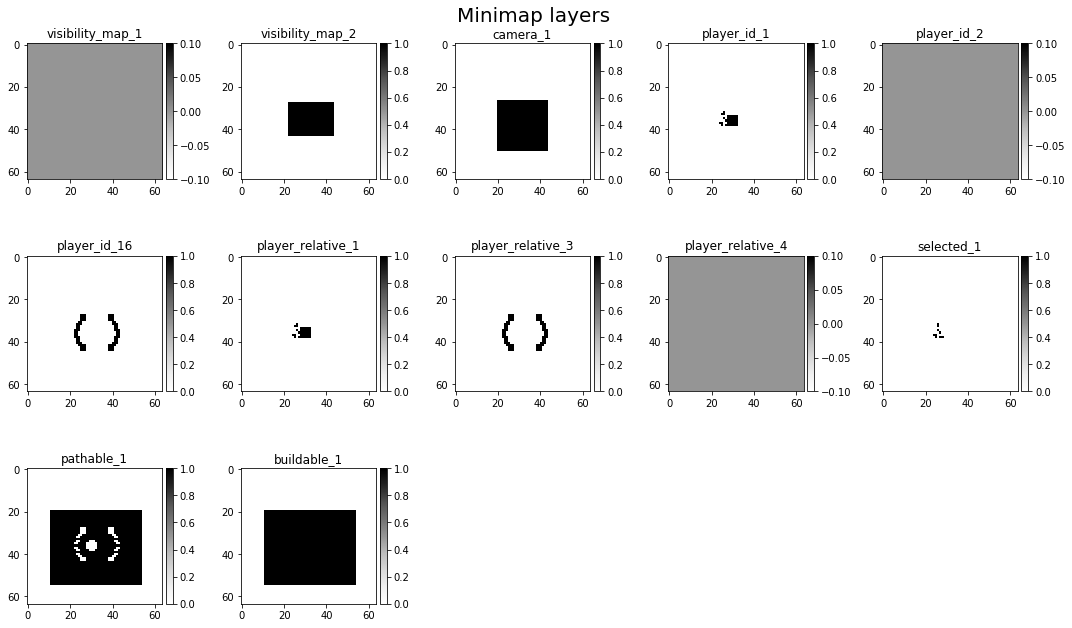

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  10

Player info: 
player_id:  1
minerals:  185
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


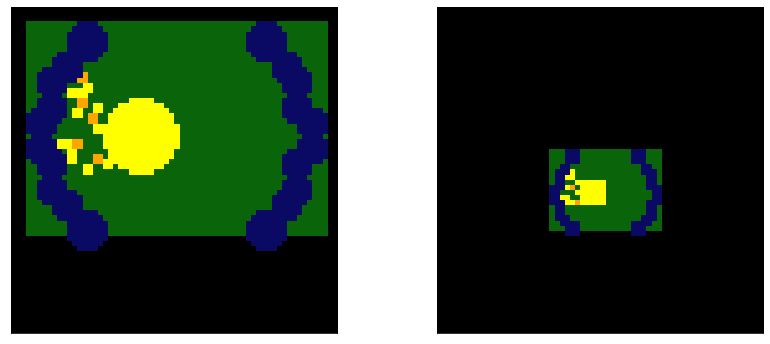

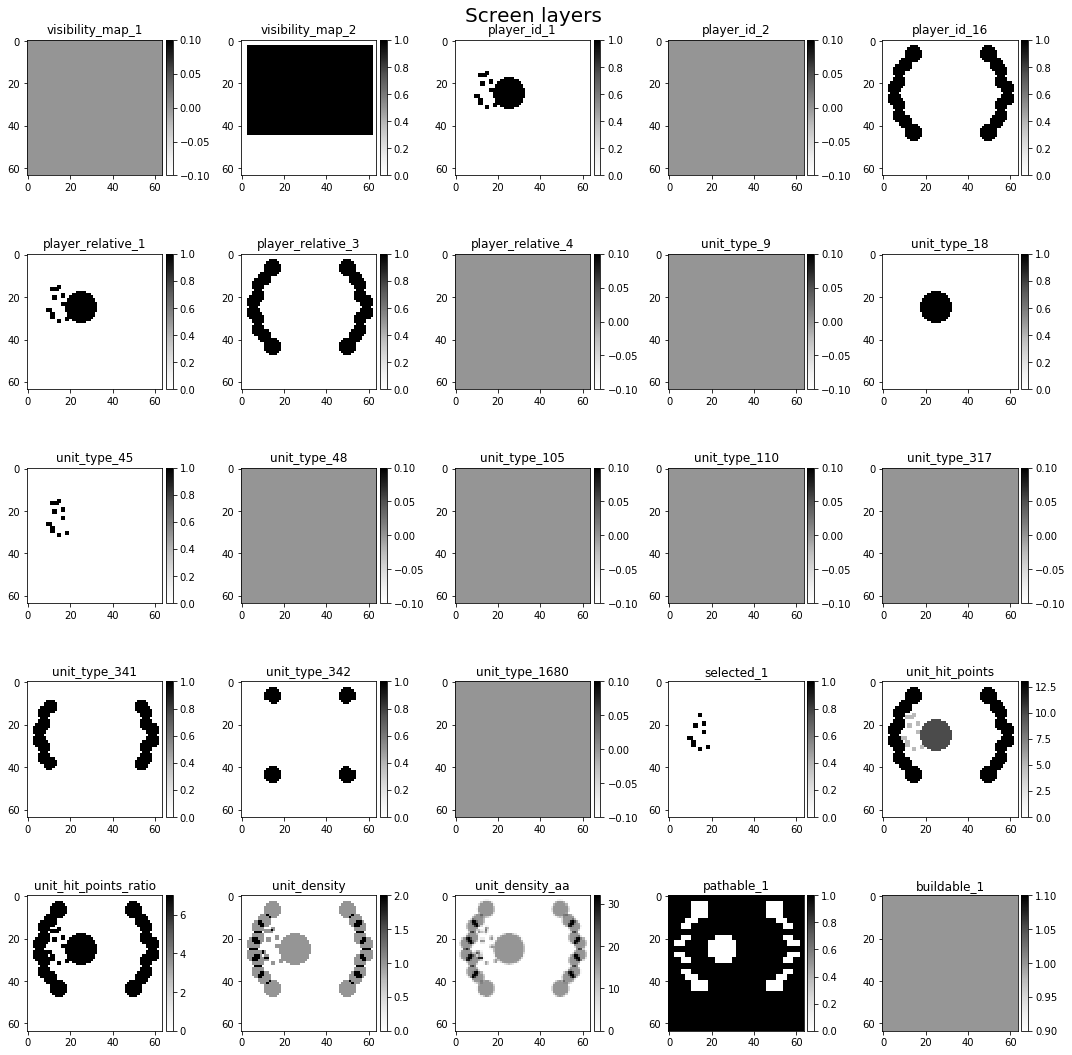

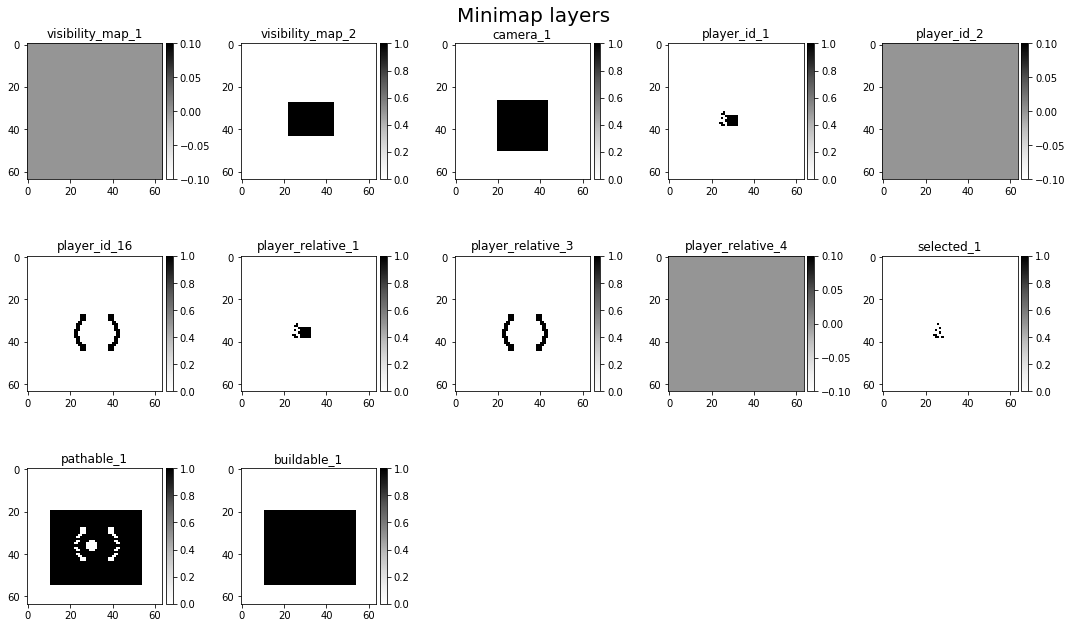

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  0

Player info: 
player_id:  1
minerals:  185
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


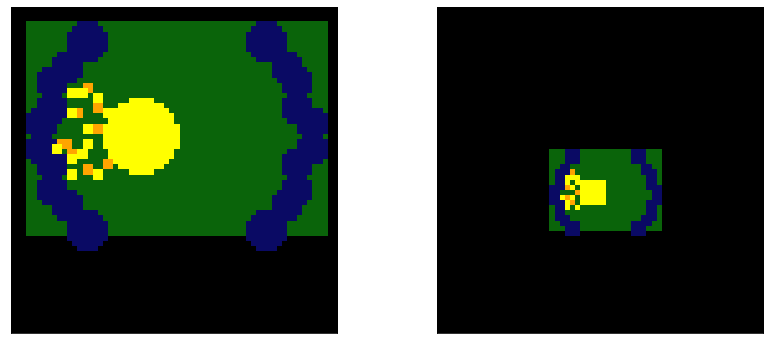

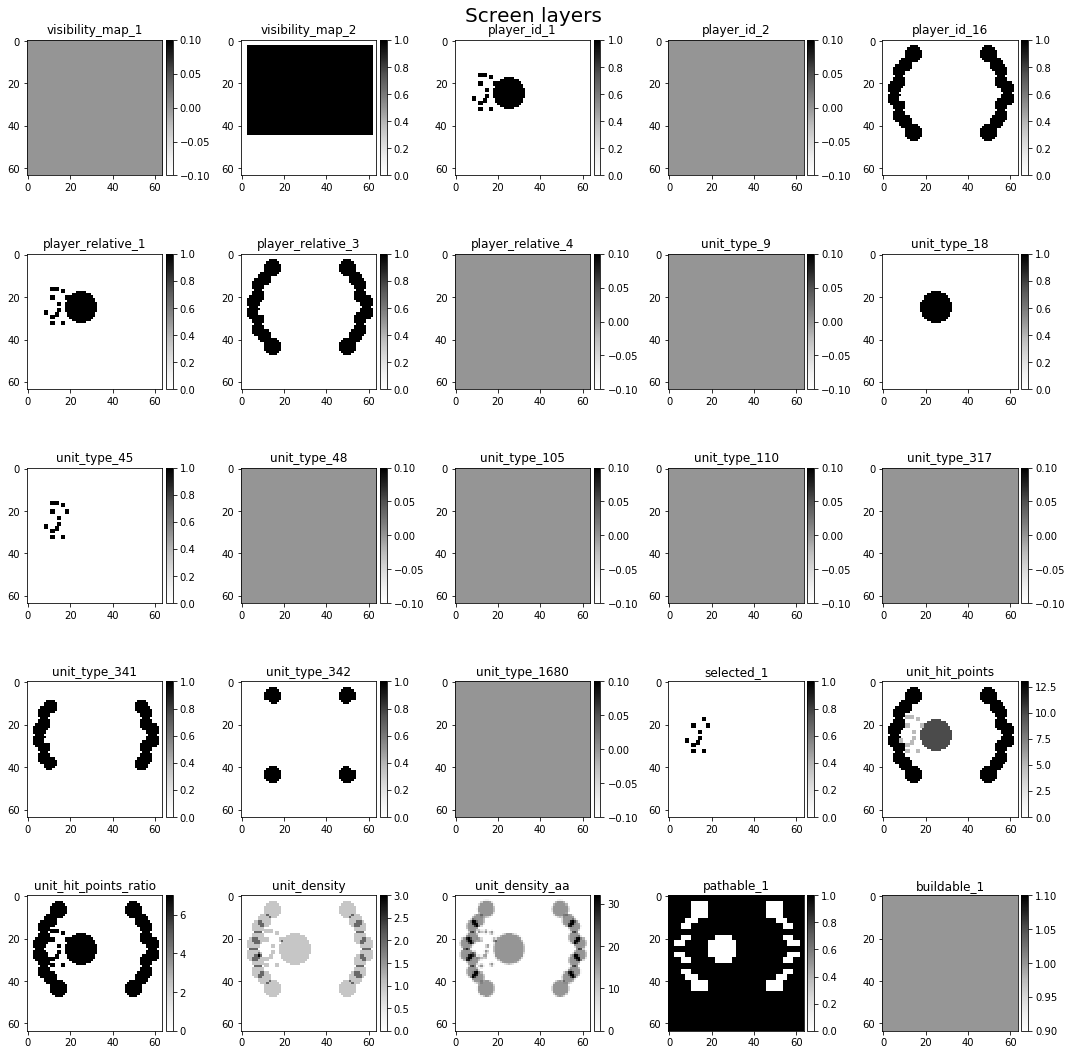

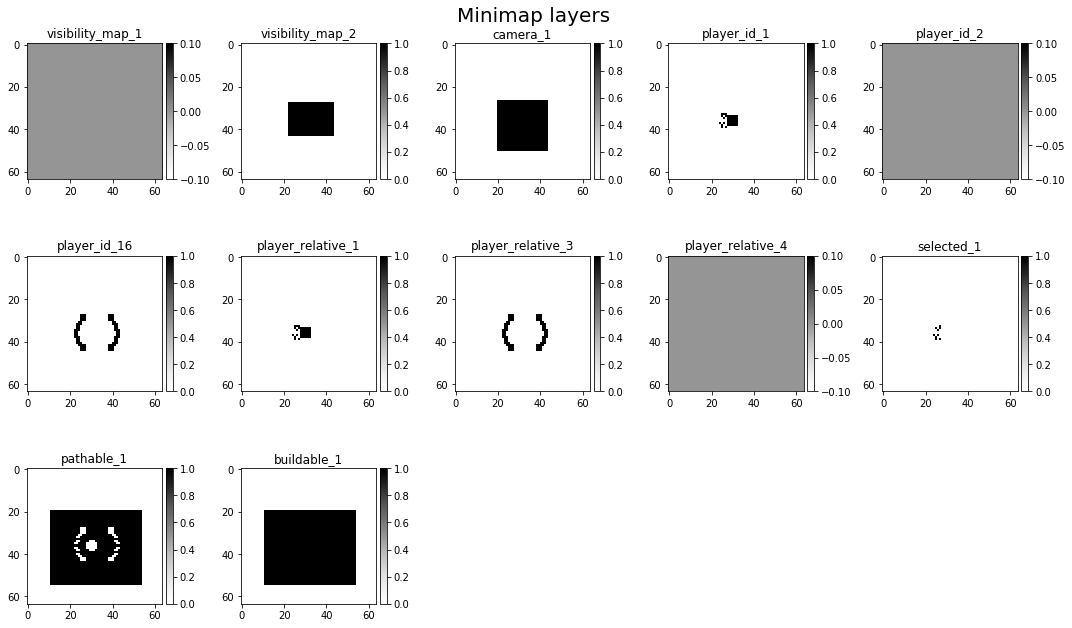

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  5

Player info: 
player_id:  1
minerals:  190
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


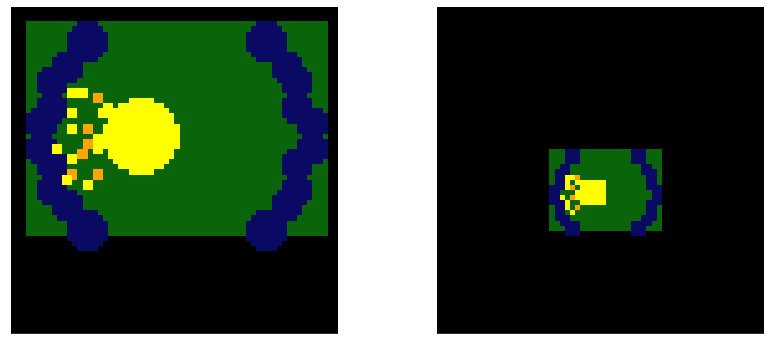

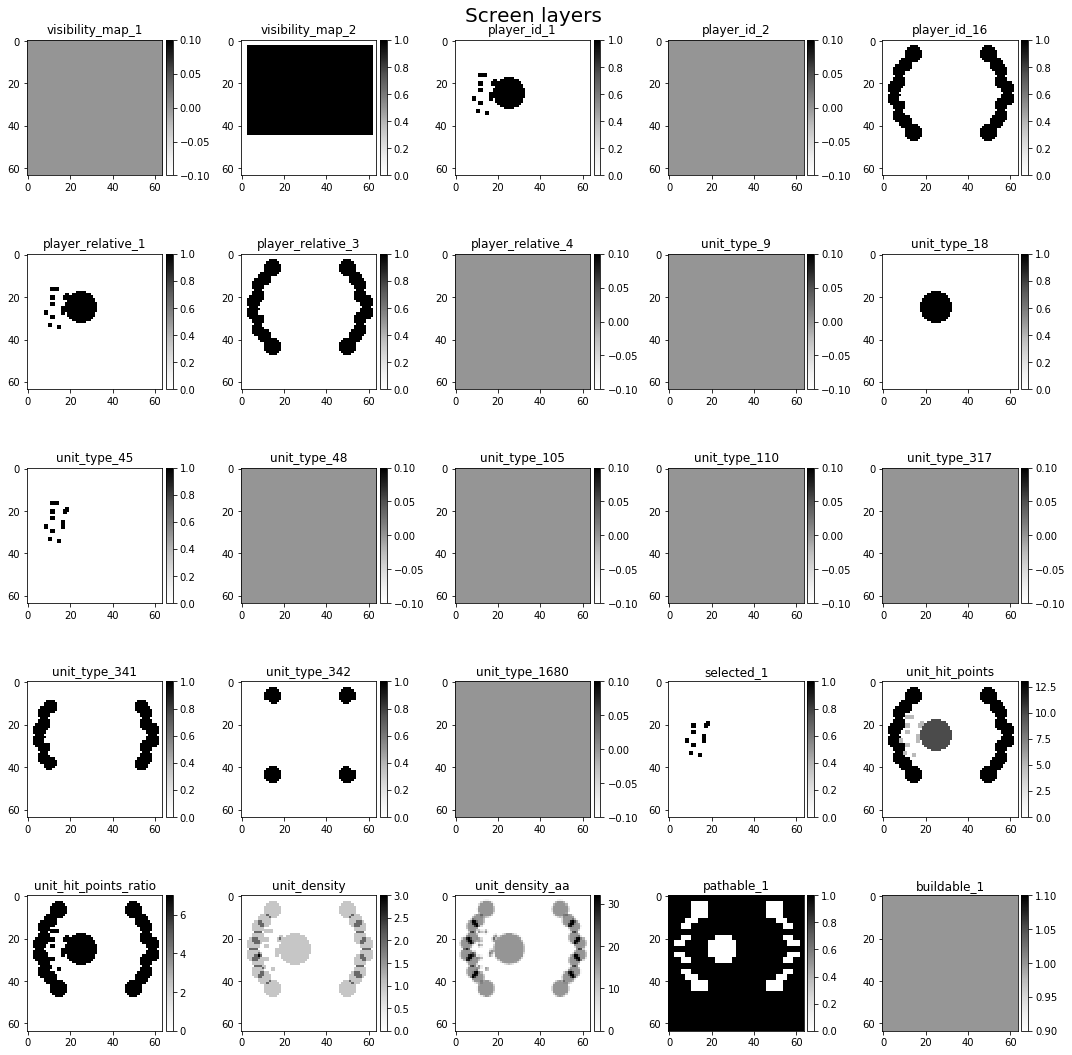

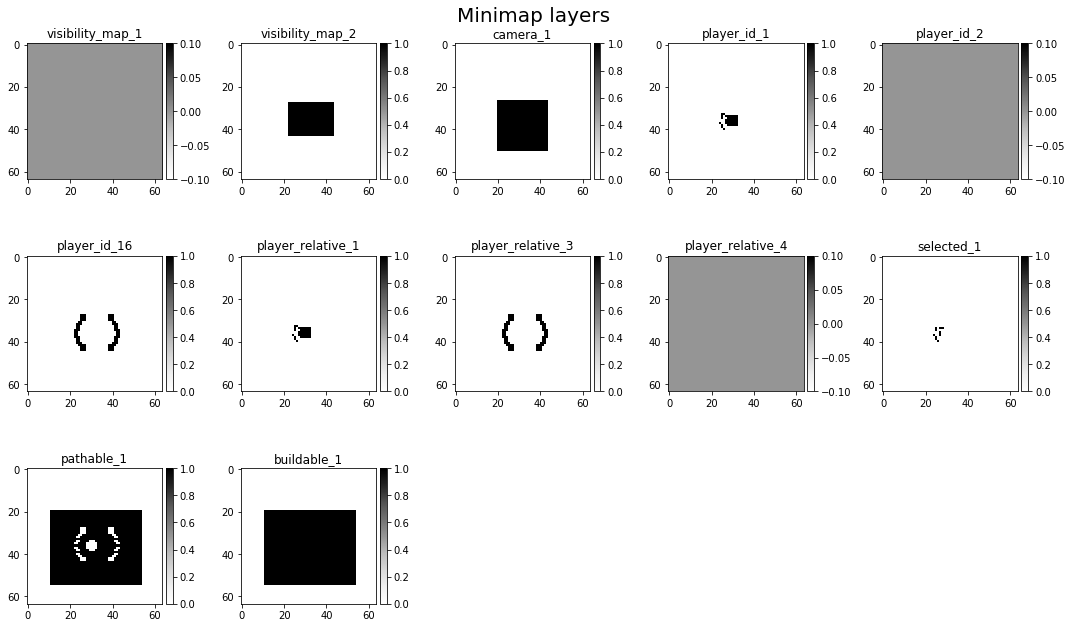

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  10

Player info: 
player_id:  1
minerals:  200
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  2
army_count:  0
warp_gate_count:  0
larva_count:  0


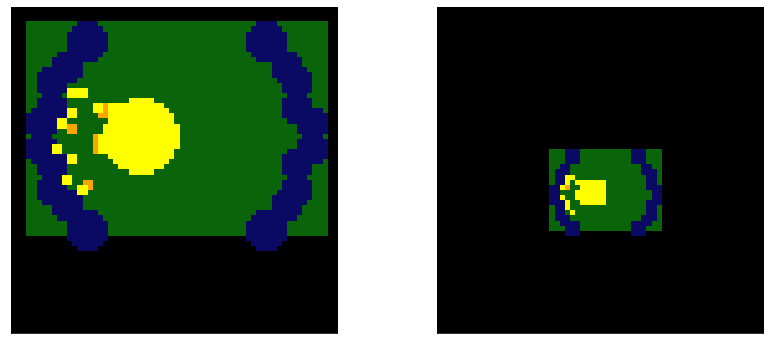

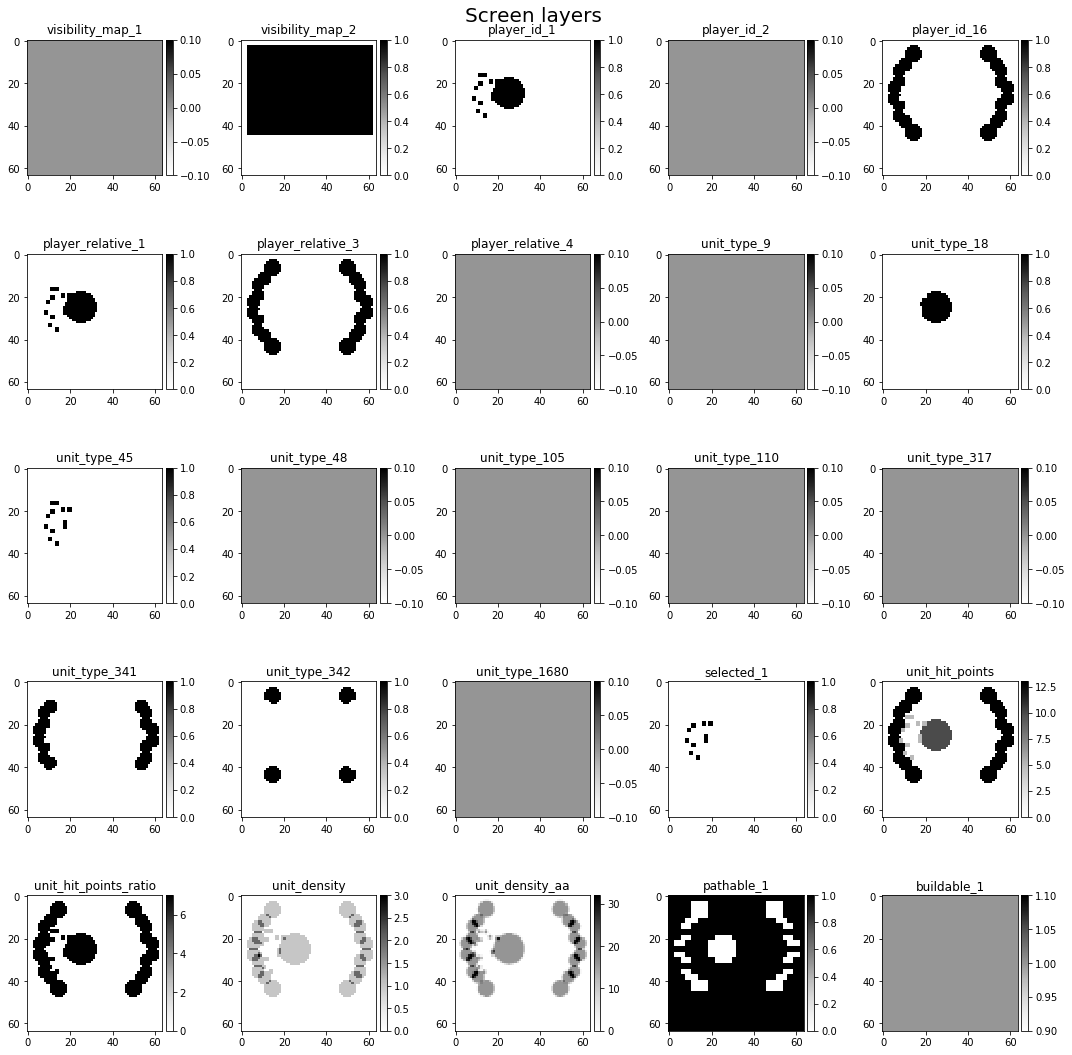

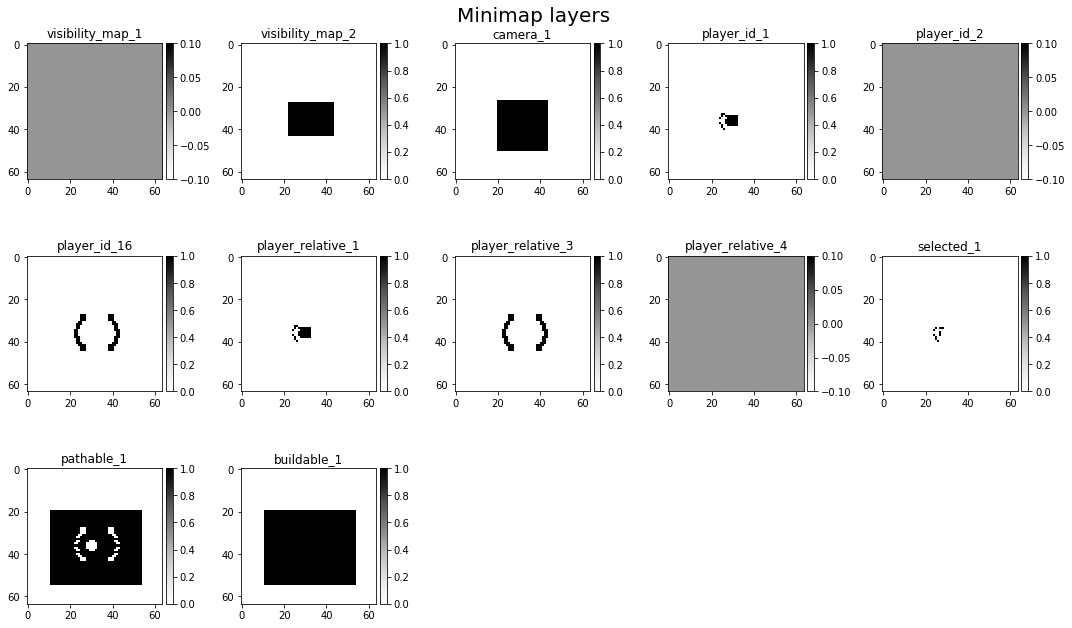

In [17]:
# 264/Harvest_Gather_screen and click on the command center
for i in range(50):
    #if i % 5 == 0:
    #    clear_output(wait=True)
    a_id = 264
    a_args = [[0],[25,25]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    if i % 10 == 0:
        iplay.interactive_step(a, show_available=False, rendering=True)
    else:
        iplay.interactive_step(a, show_available=False, rendering=False)

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  5
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen 

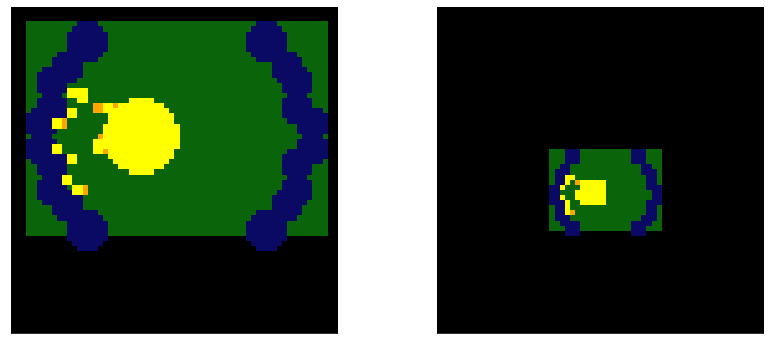

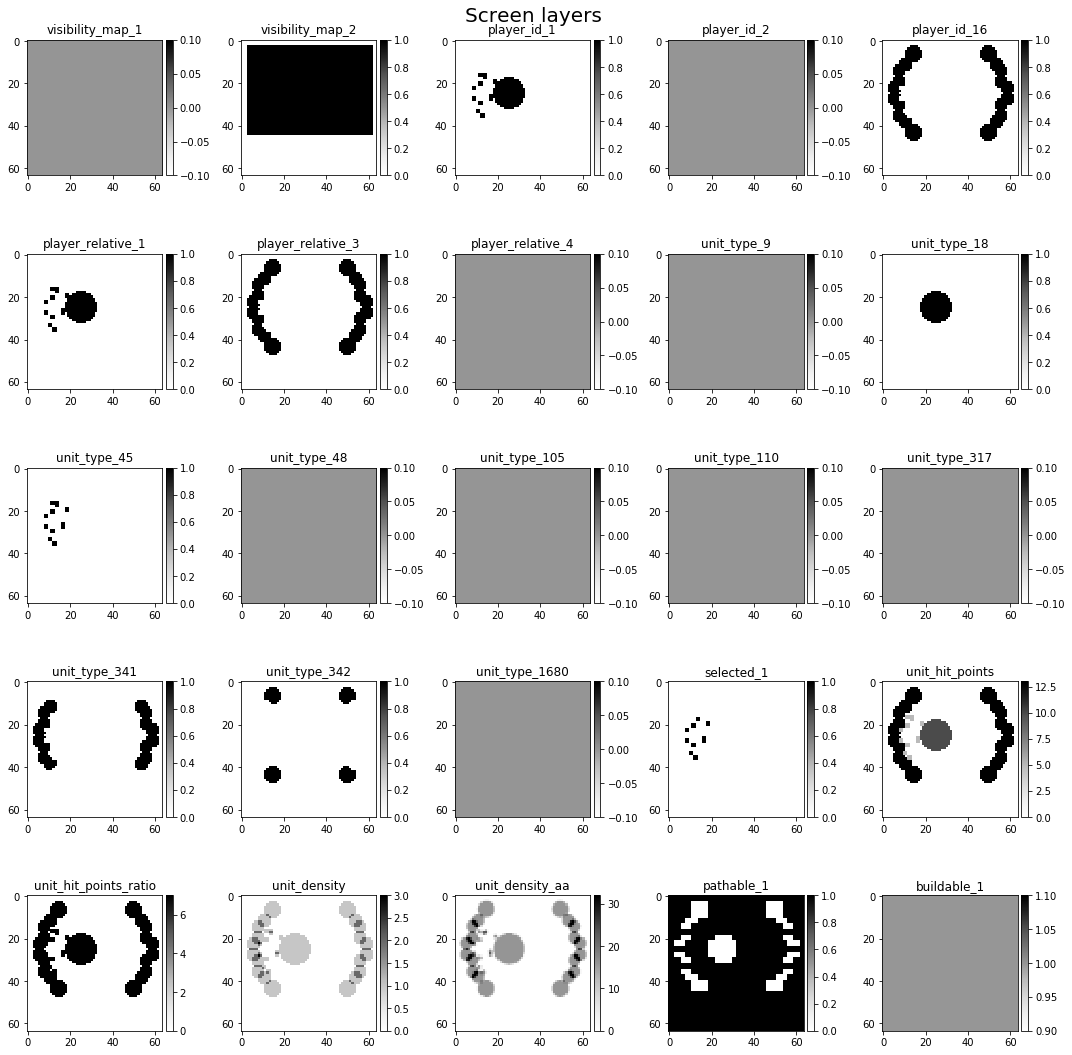

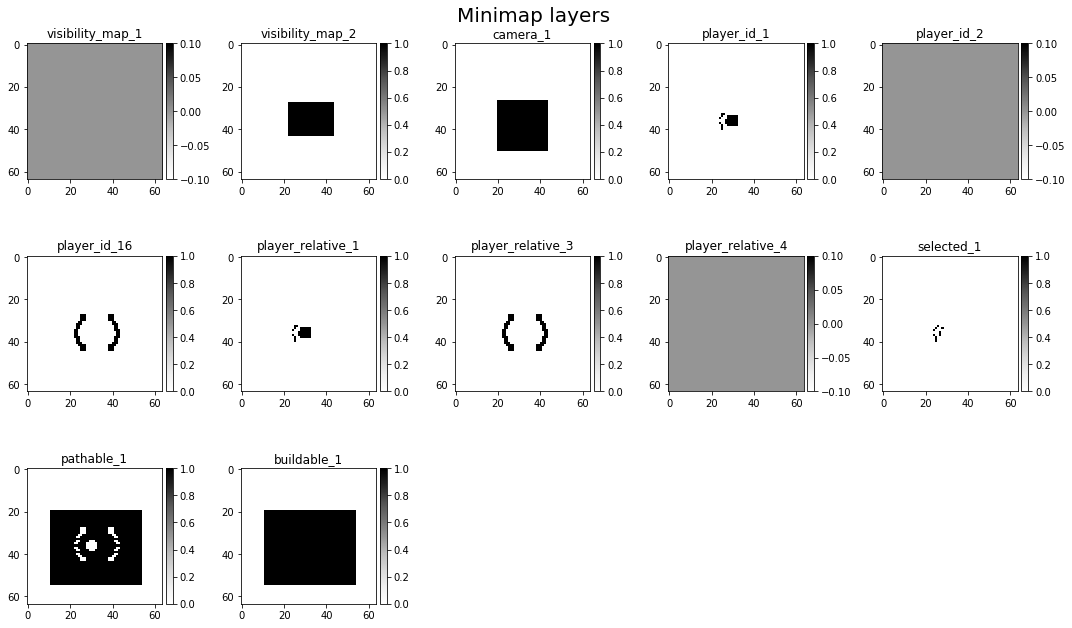

In [18]:
# 264/Harvest_Gather_screen
for i in range(1):
    a_id = 264
    a_args = [[0],[25,25]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=6, arguments=[[0]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap 

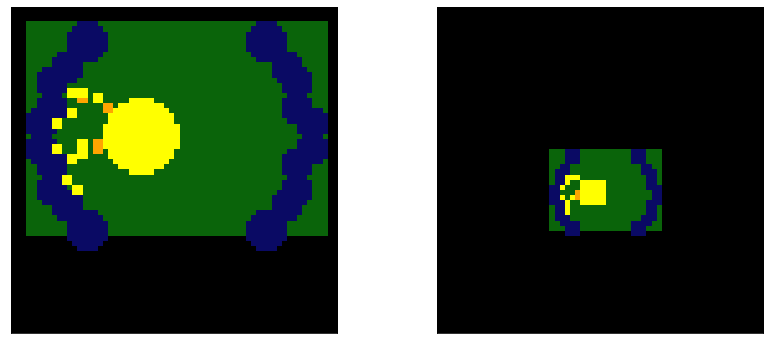

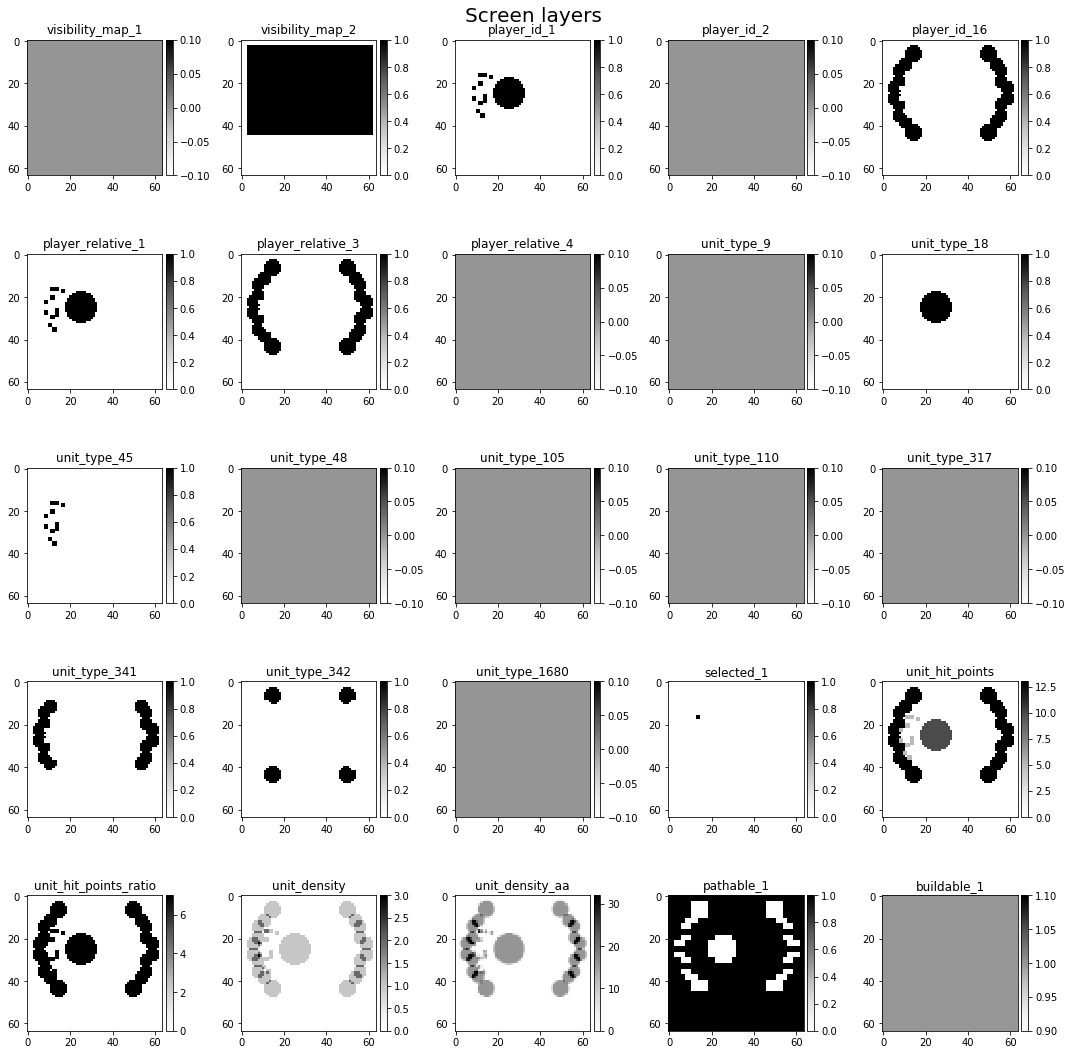

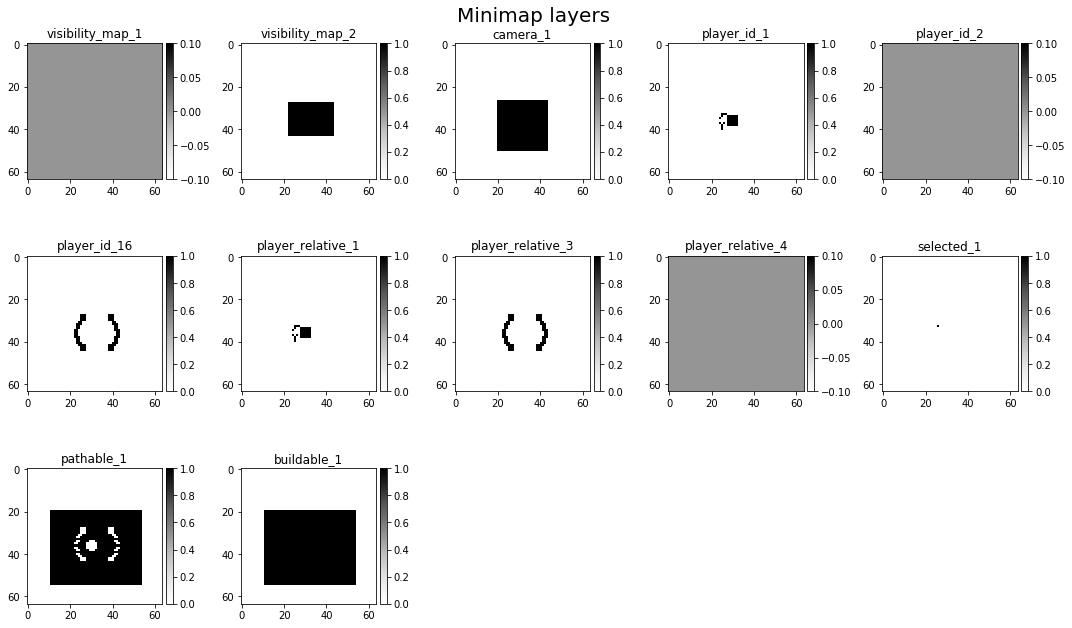

In [19]:
# Get idle worker and build refinery 
# 6/select_idle_worker (10/select_worker [4])
a_id = 6
a_args = [[0]] # no idea what this argument does
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=79, arguments=[[0], [15, 10]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2];

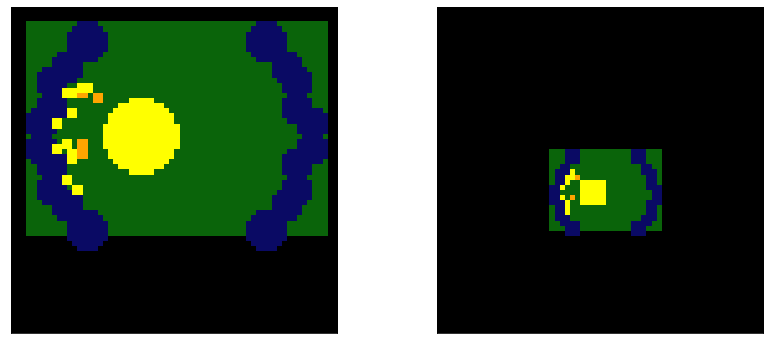

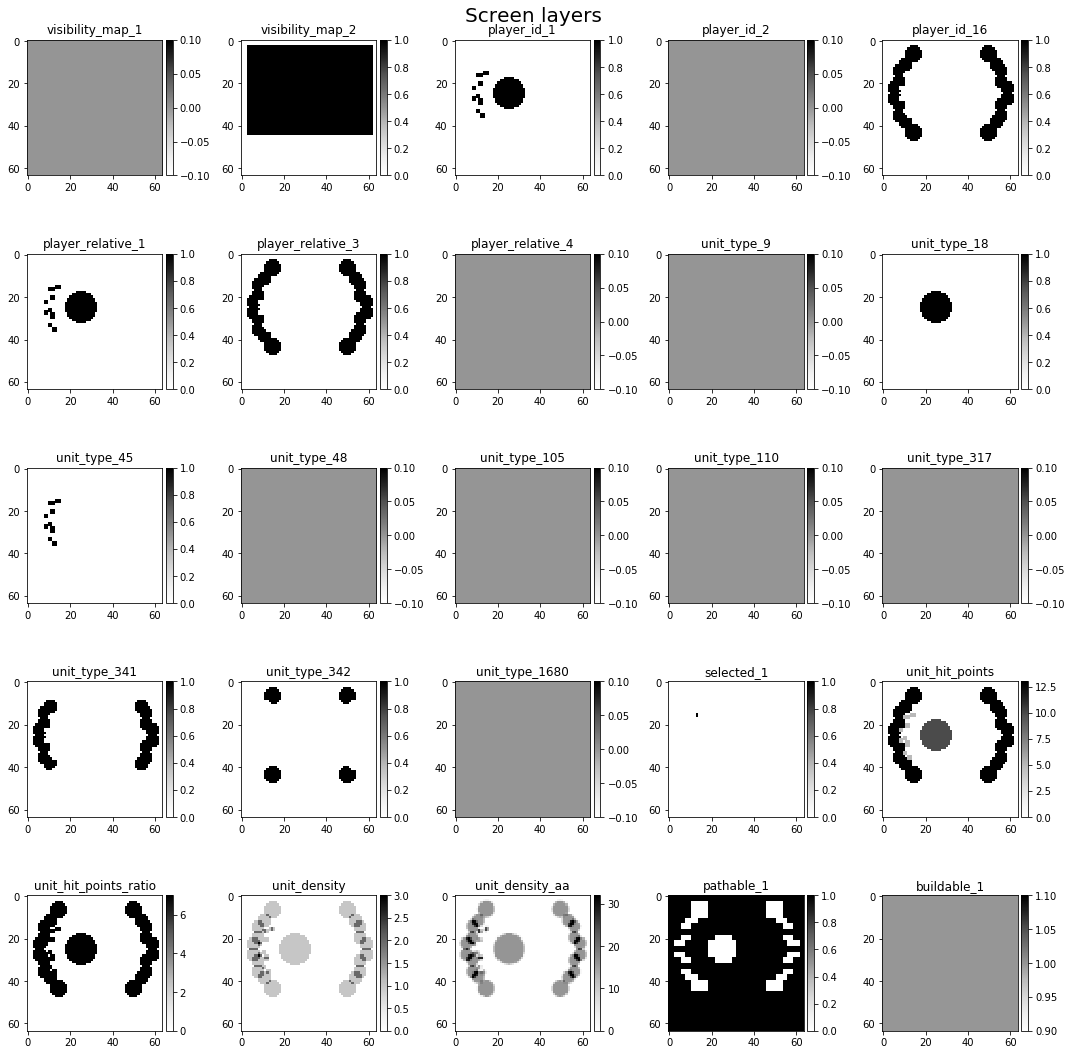

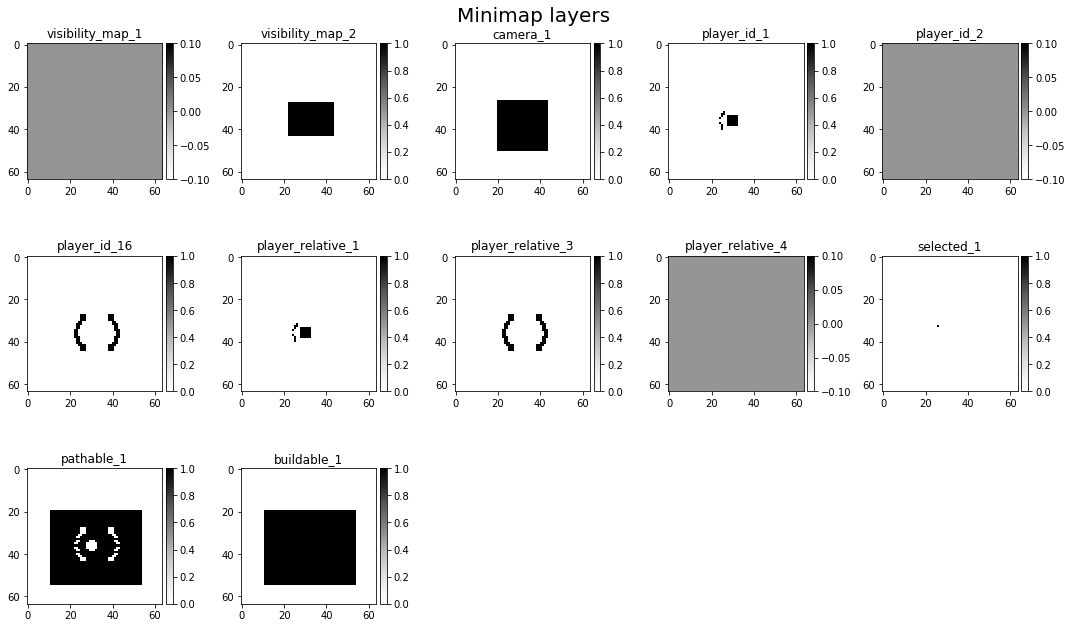

In [20]:
# Get idle worker and build refinery 
#79/Build_Refinery_screen (3/queued [2]; 0/screen [0, 0]) 
a_id = 79
a_args = [[0],[15,10]] # trying to aim at one of the 4 gas spots
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

In my experiment the refinery costs 75 of minerals, but does not give a negative reward (objective is to collect and not to store resources)

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  130
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0


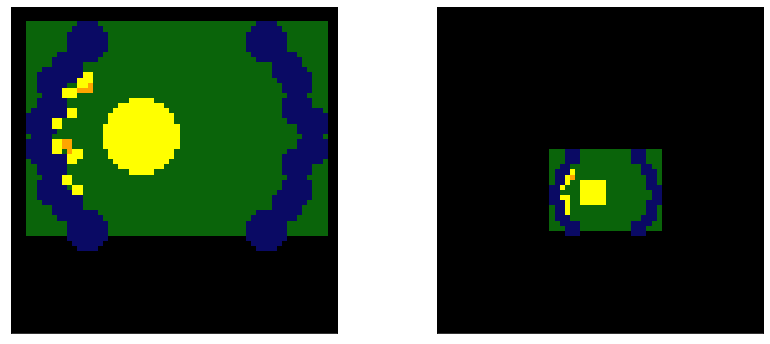

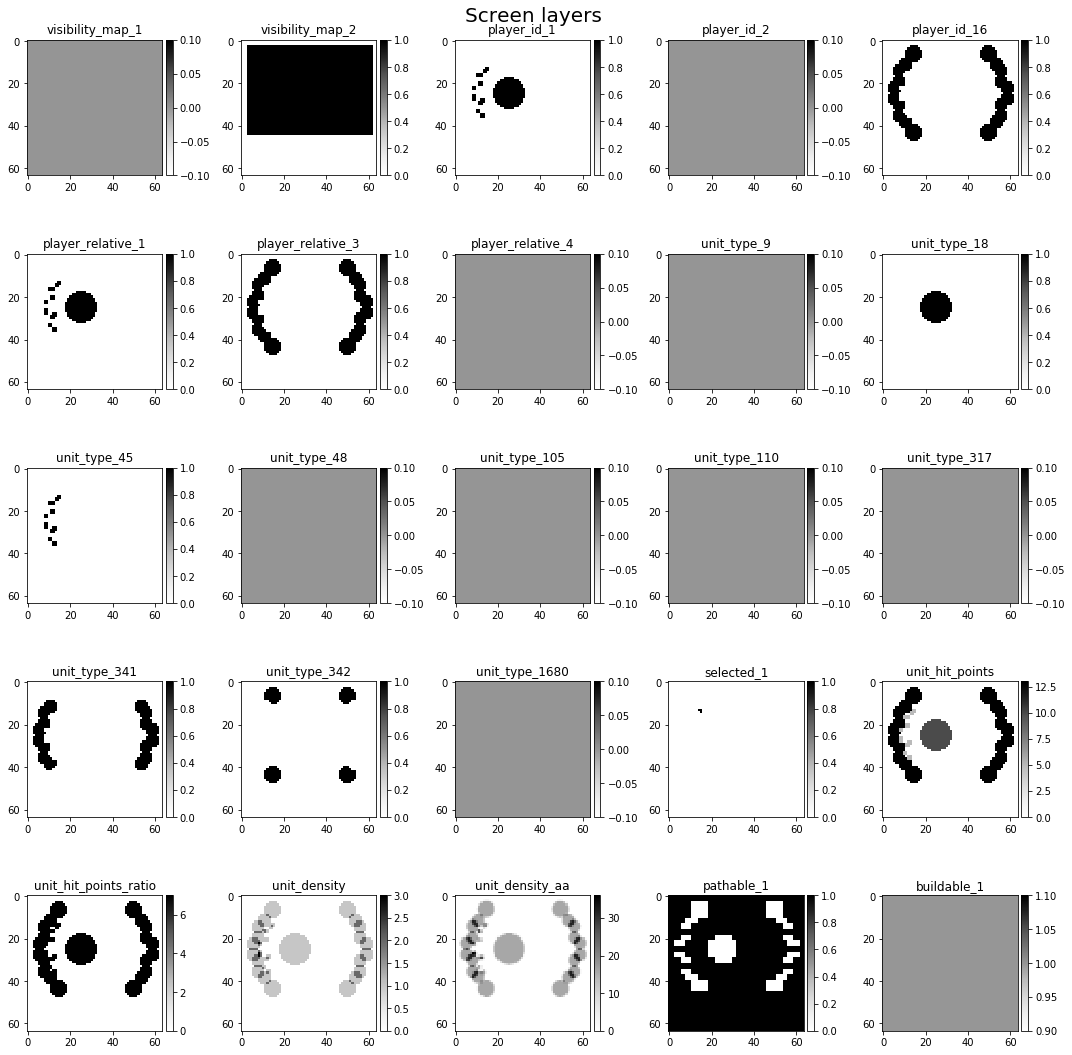

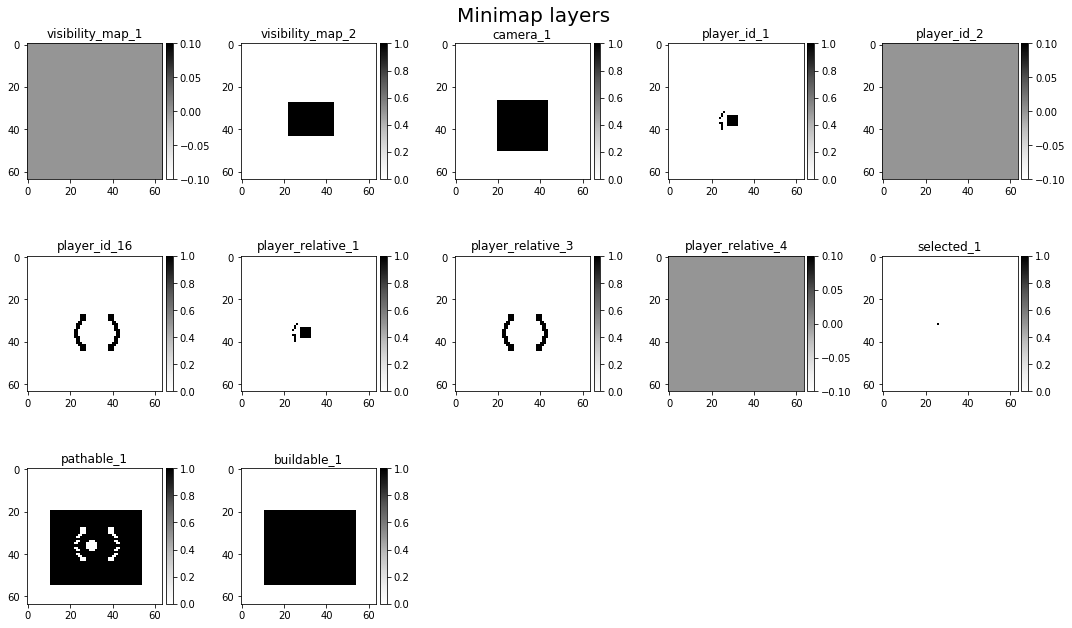

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  130
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0


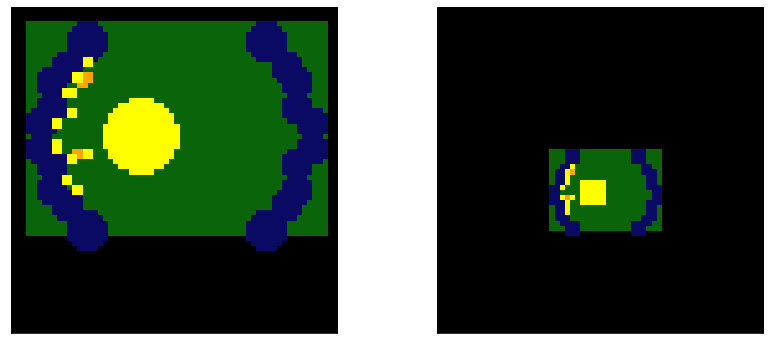

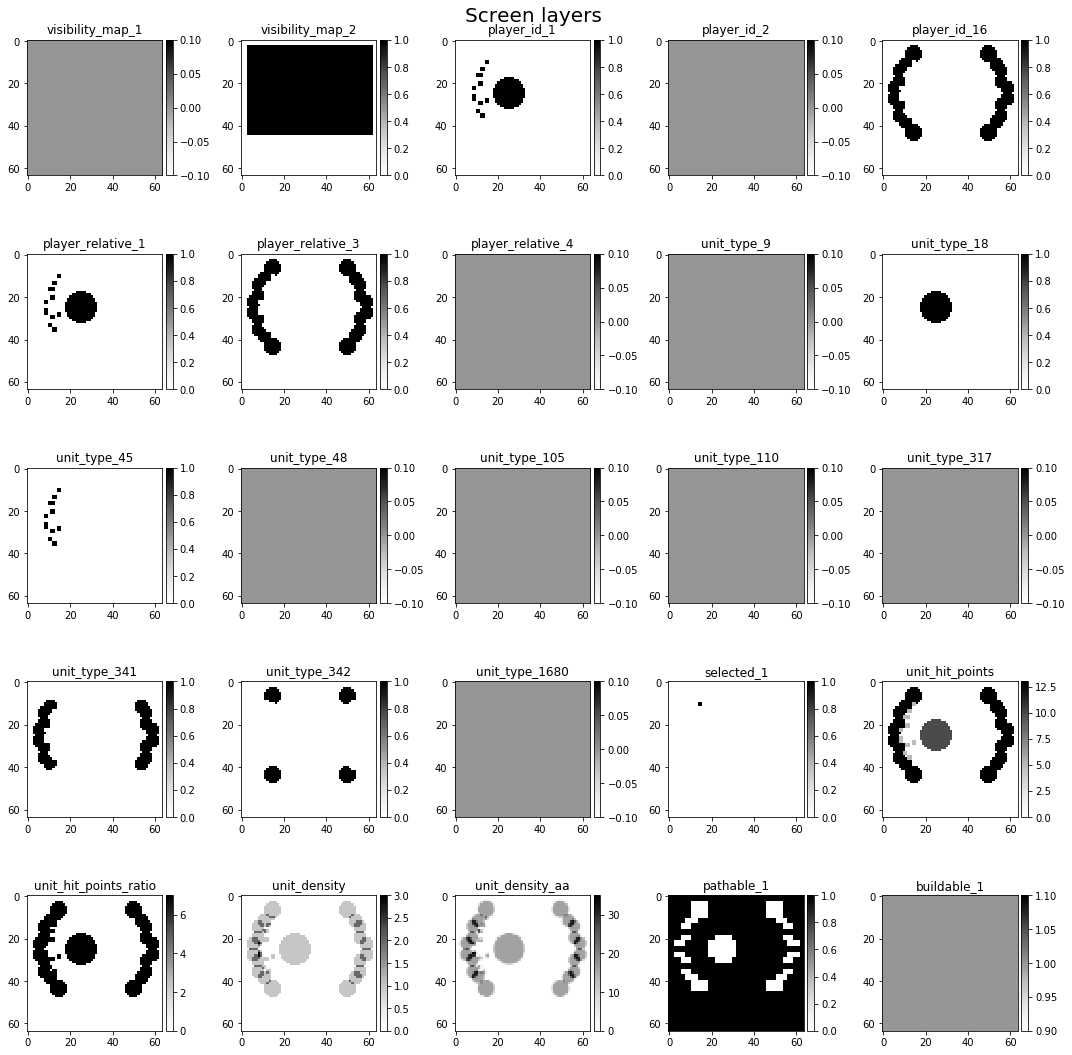

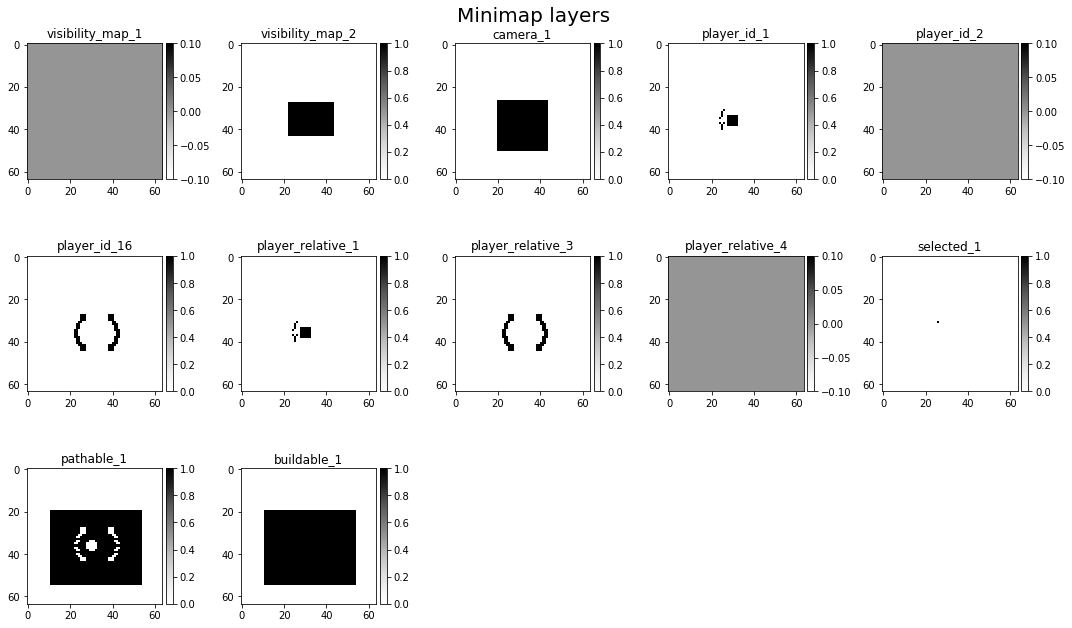

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  130
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


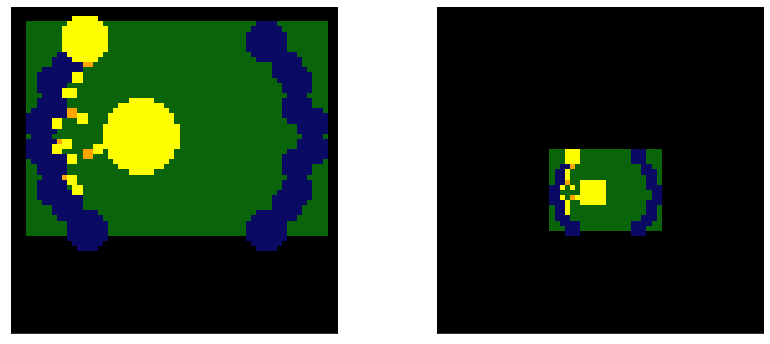

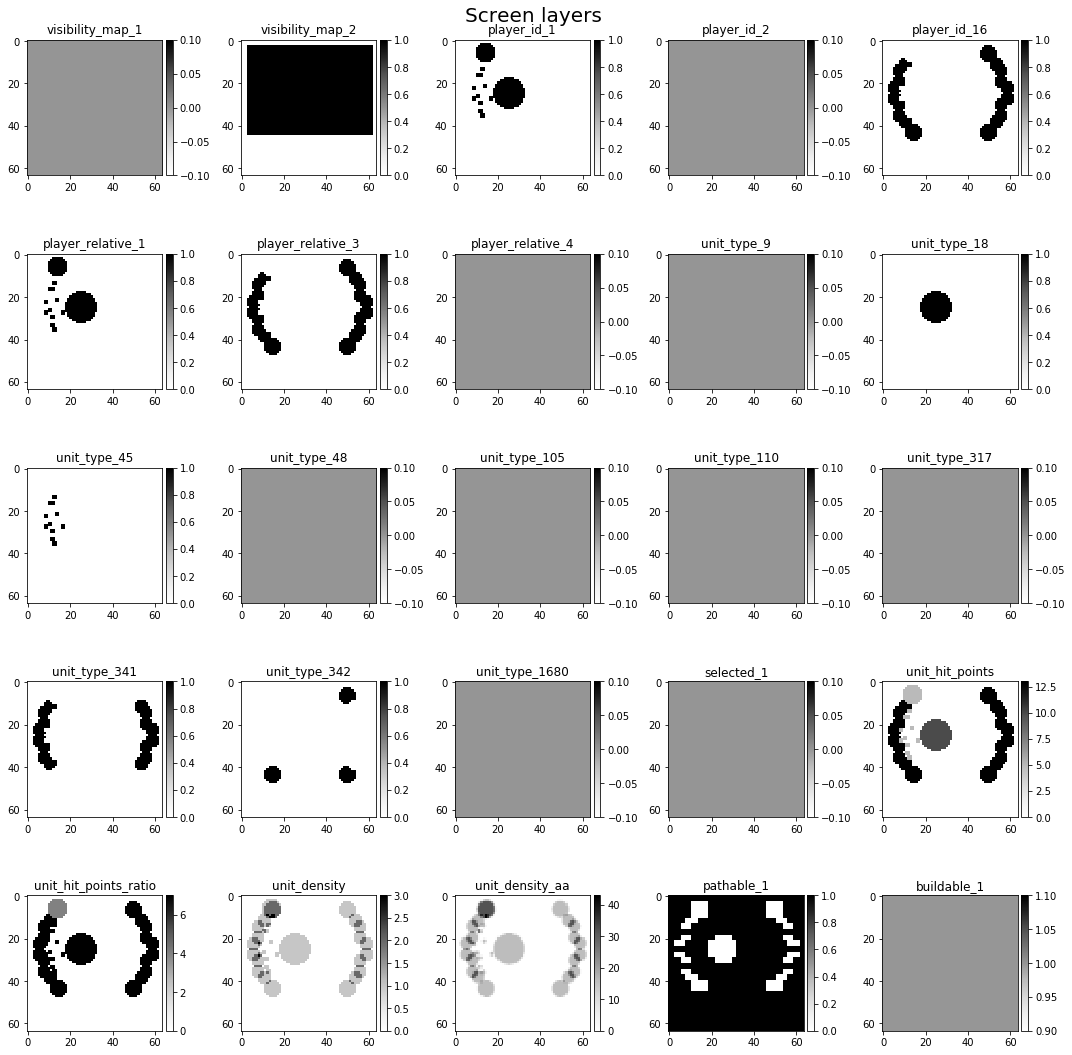

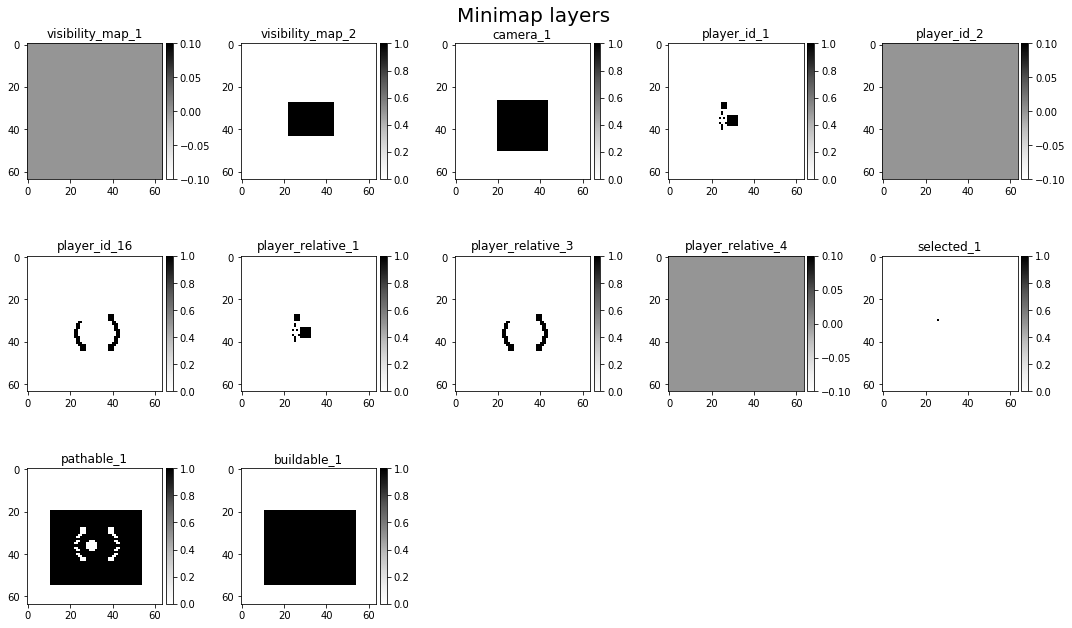

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  5

Player info: 
player_id:  1
minerals:  135
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


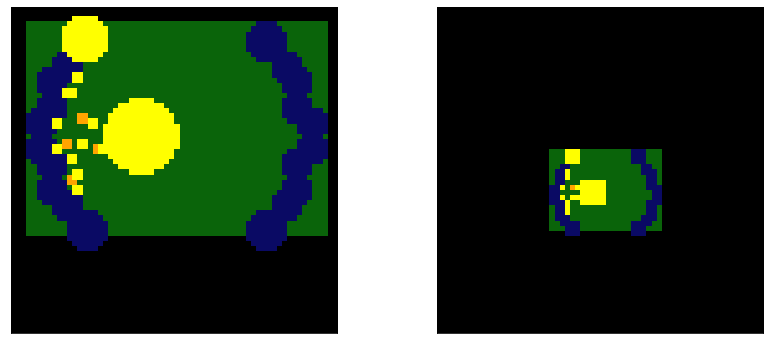

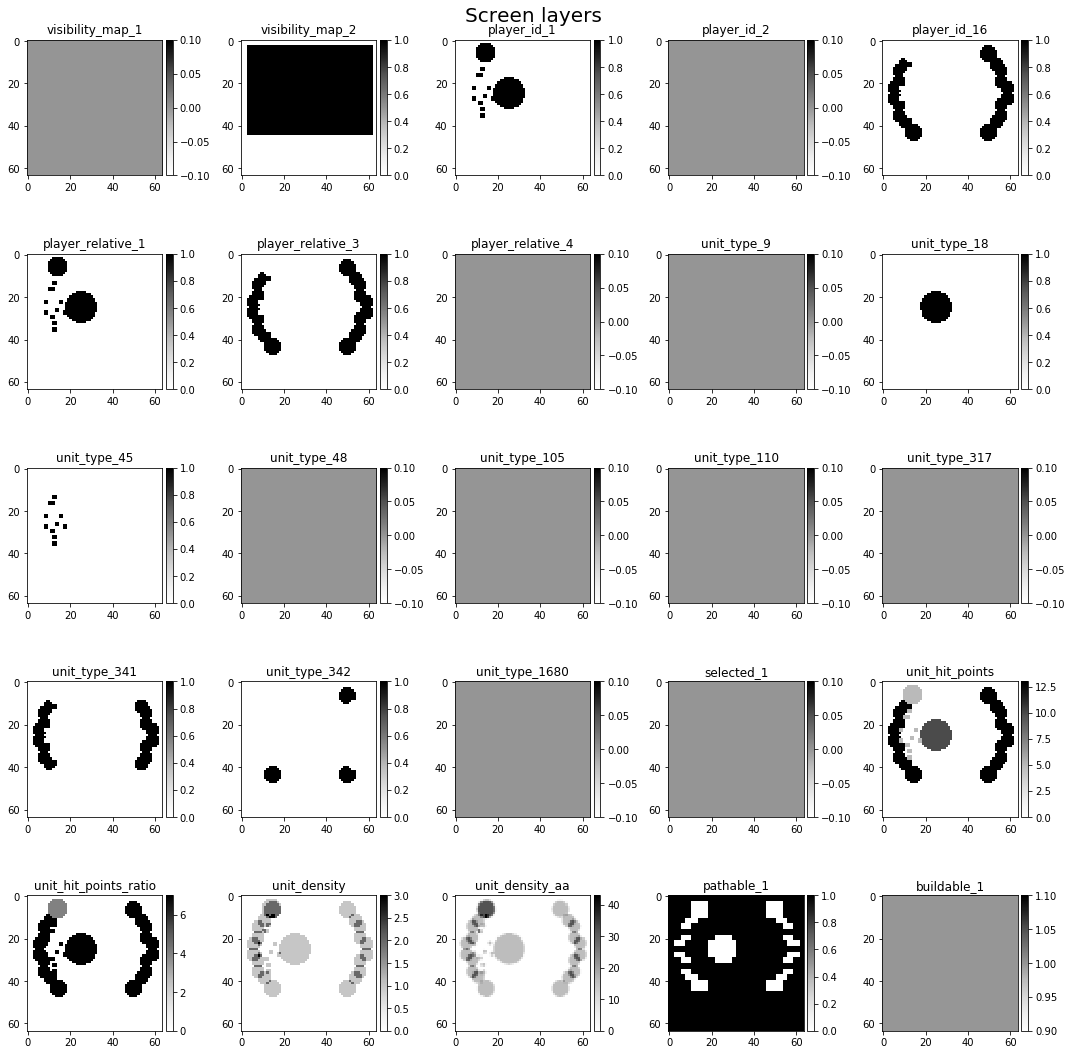

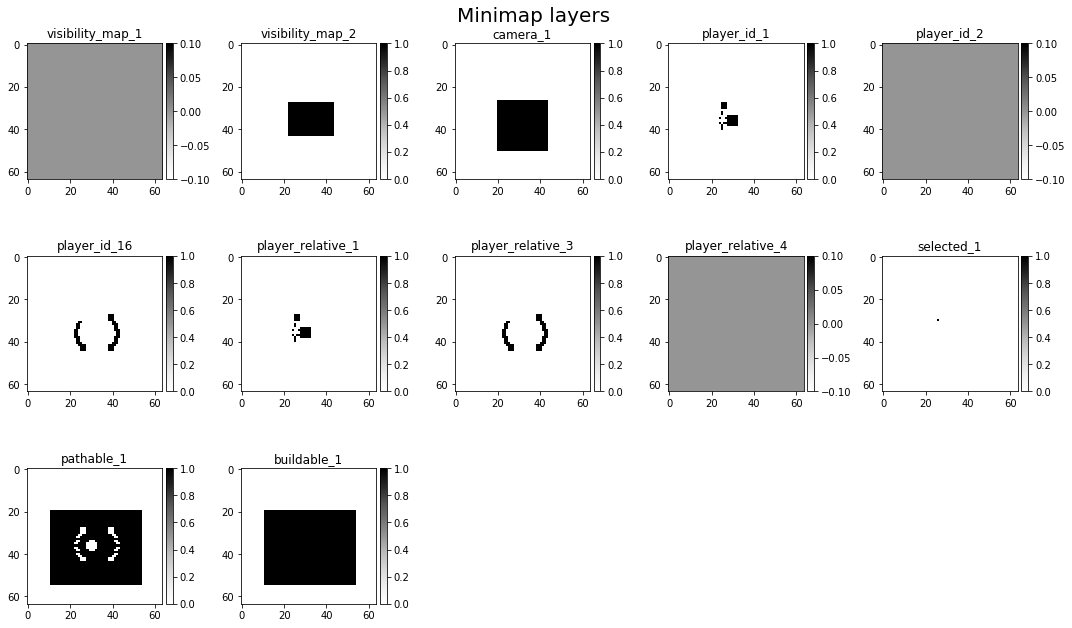

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  135
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


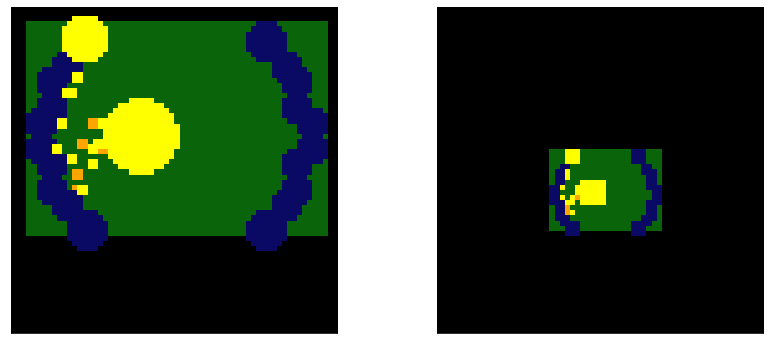

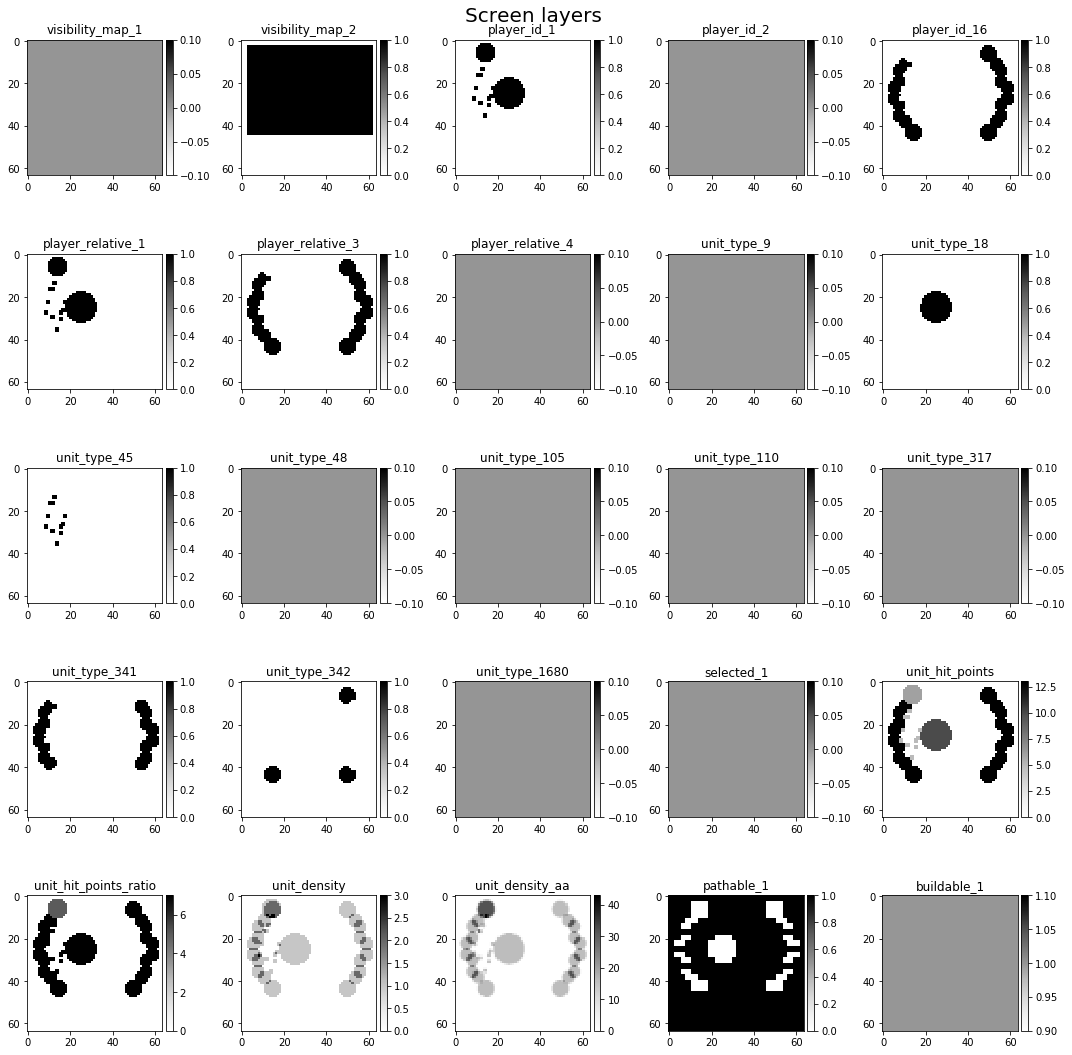

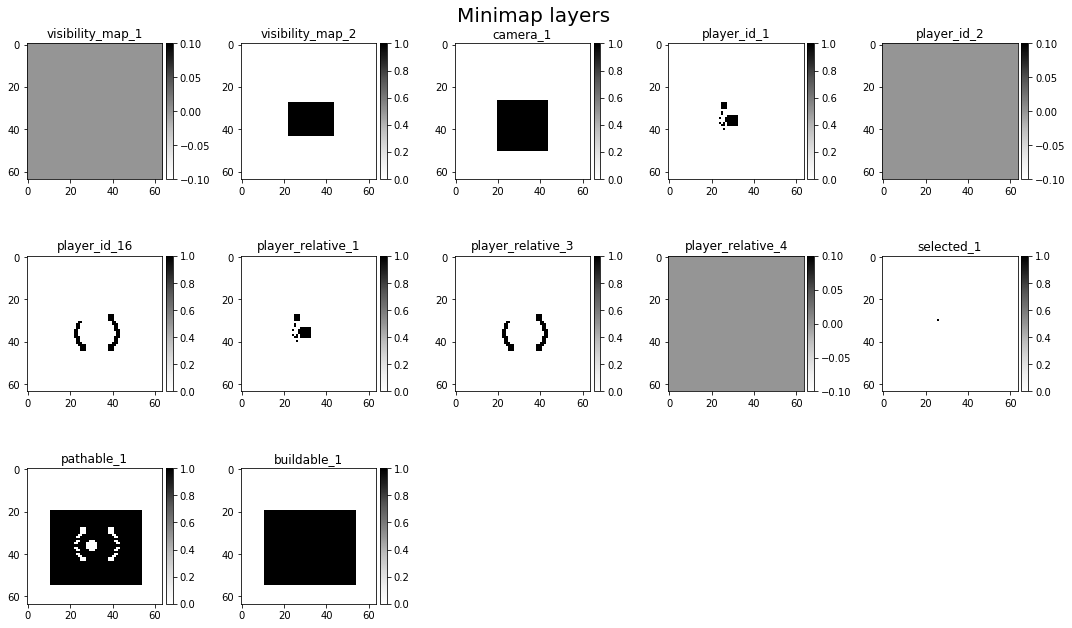

In [23]:
# let's wait a bit
for i in range(5):
    #0/no_op ()
    a_id = 0
    a_args = [] 
    a = [sc_actions.FunctionCall(a_id, a_args)]
    #if i != 4:
    #    iplay.interactive_step(a, show_available=False, rendering=False)
    #else:
    #    iplay.interactive_step(a, show_available=False, rendering=True)
    iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=6, arguments=[[0]])
Reward:  5
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap 

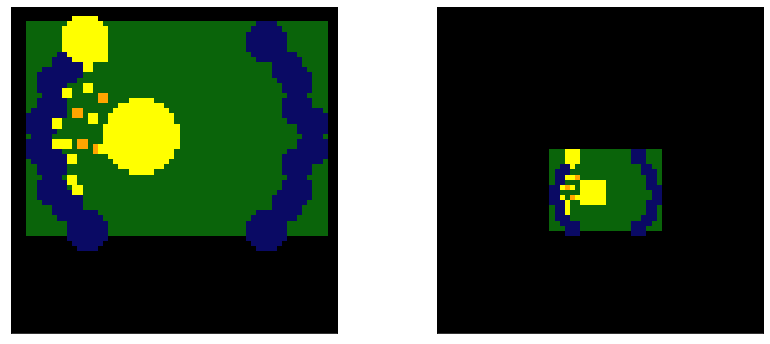

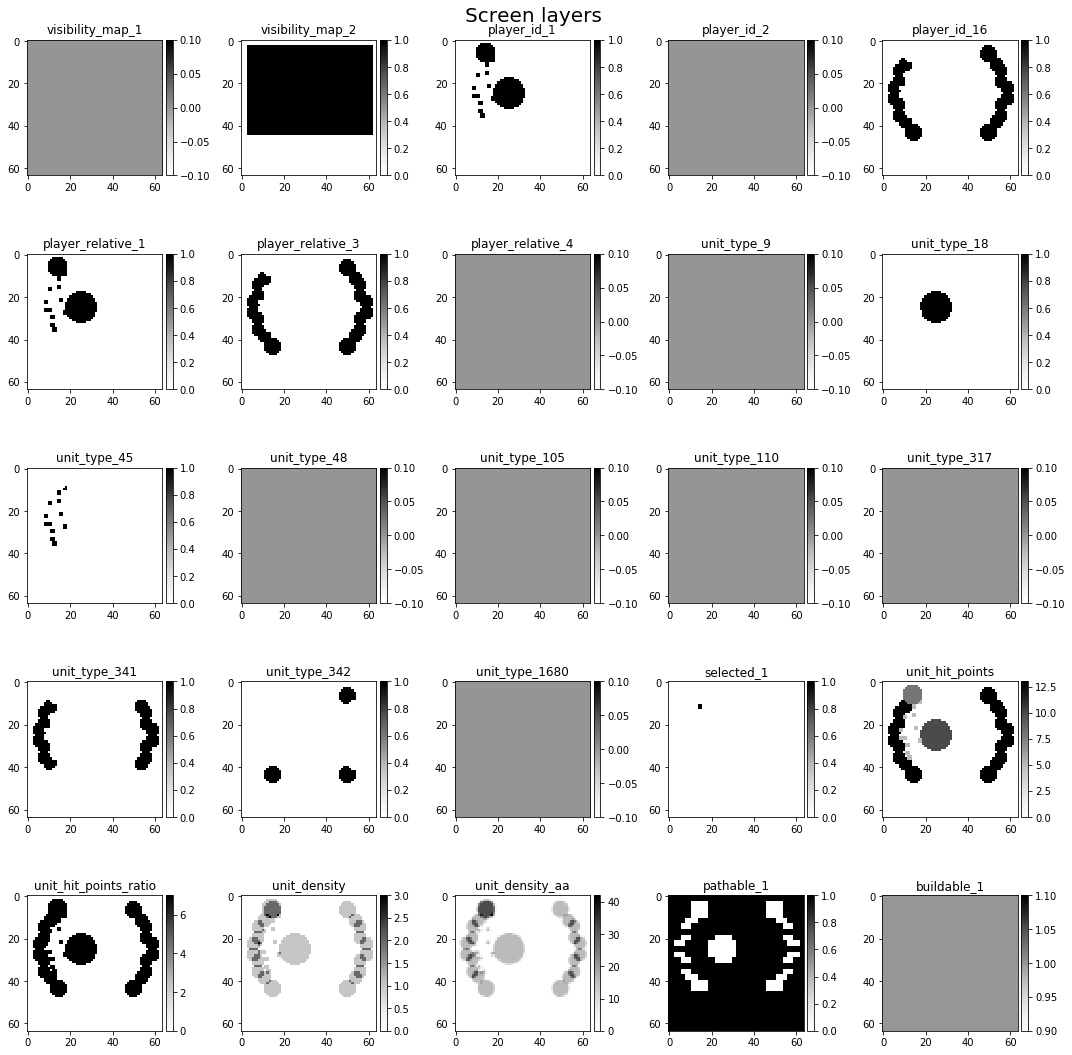

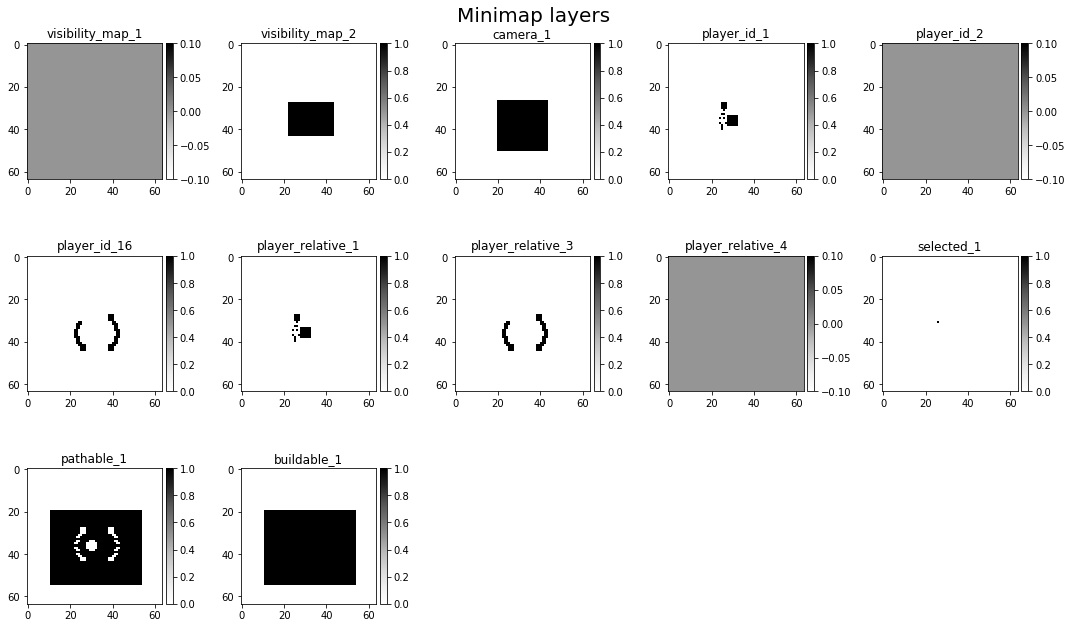

In [33]:
# select other idle worker and send it to collect minerals from there
# 6/select_idle_worker (10/select_worker [4])
a_id = 6
a_args = [[0]] # no idea what this argument does
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=264, arguments=[[0], [14, 9]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2];

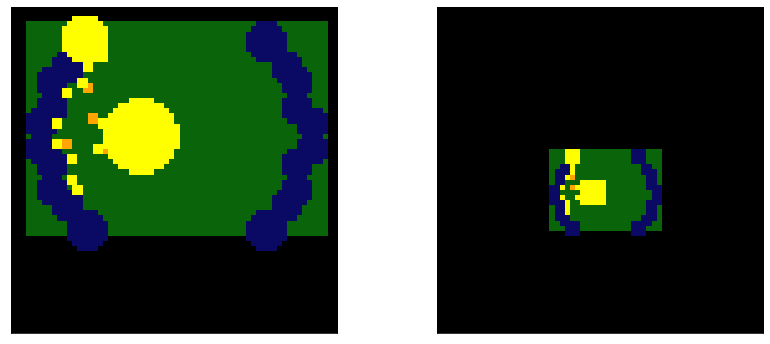

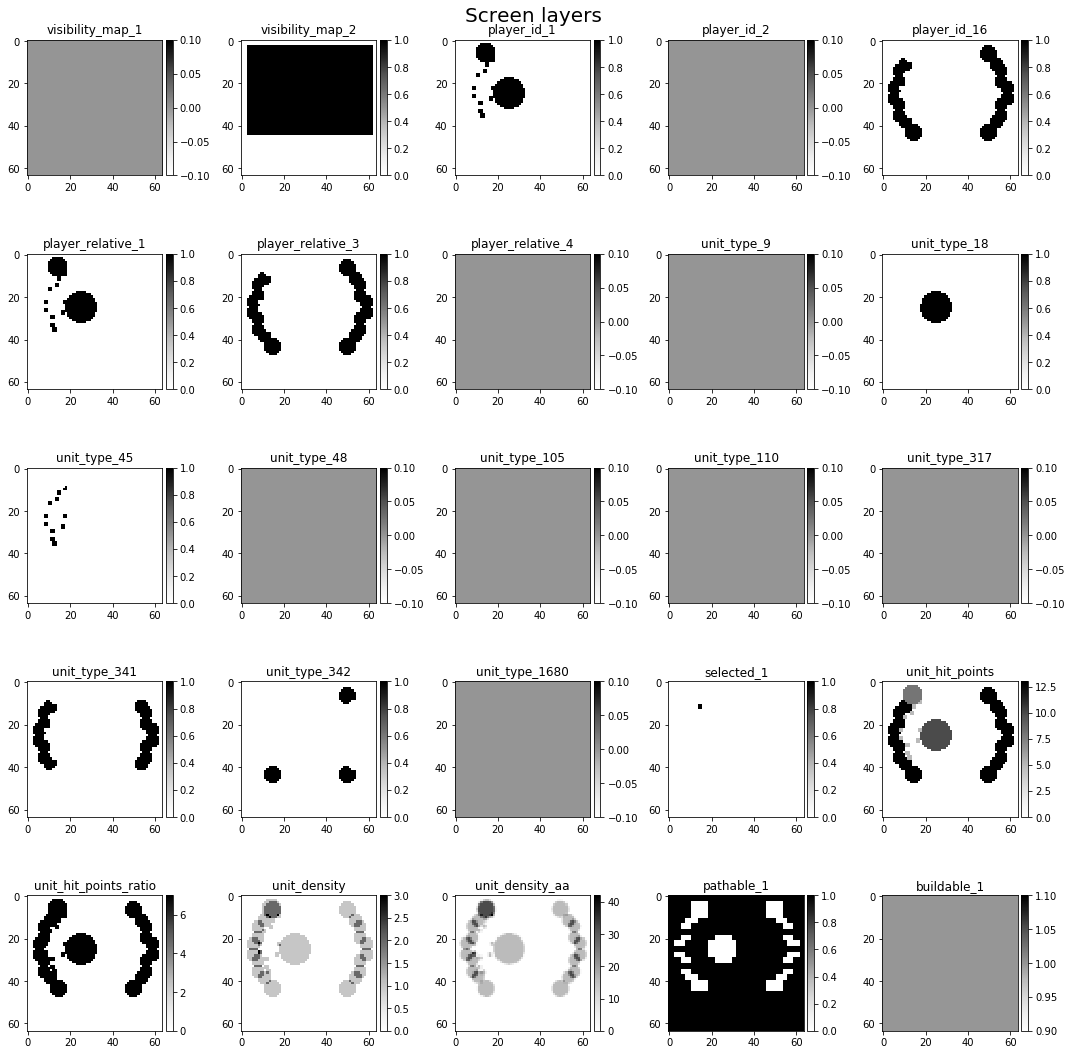

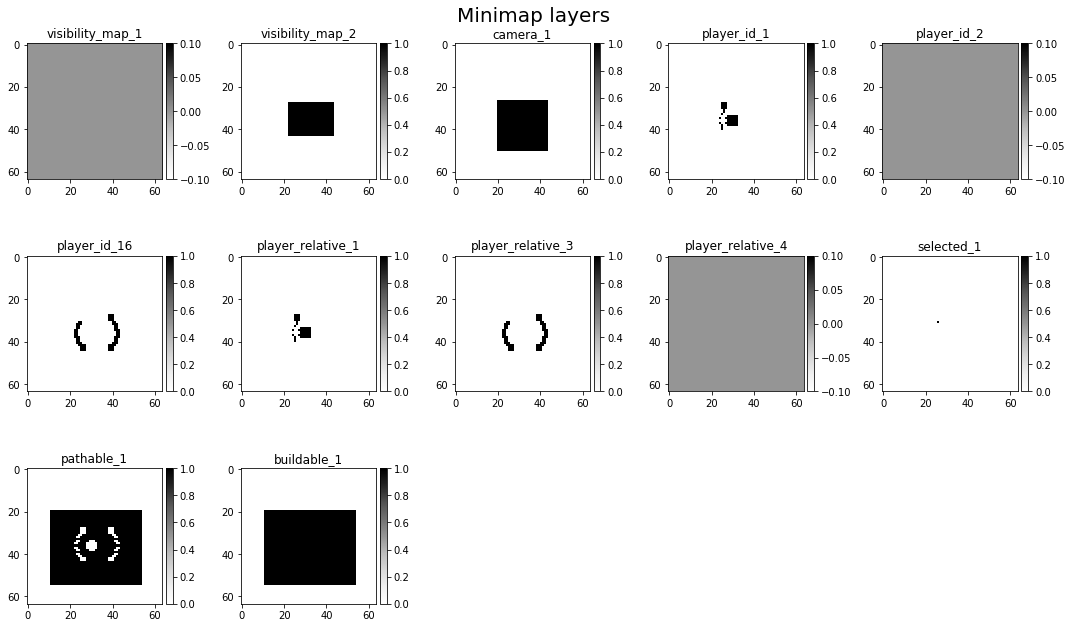

In [34]:
# select other idle worker and send it to collect minerals from there
# 264/Harvest_Gather_screen
for i in range(1):
    a_id = 264
    a_args = [[0],[14,9]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  255
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


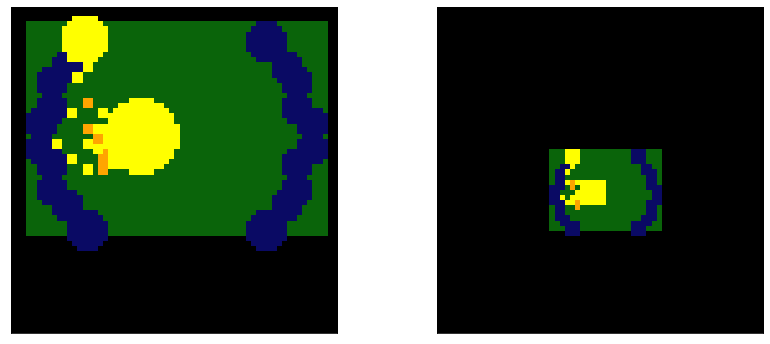

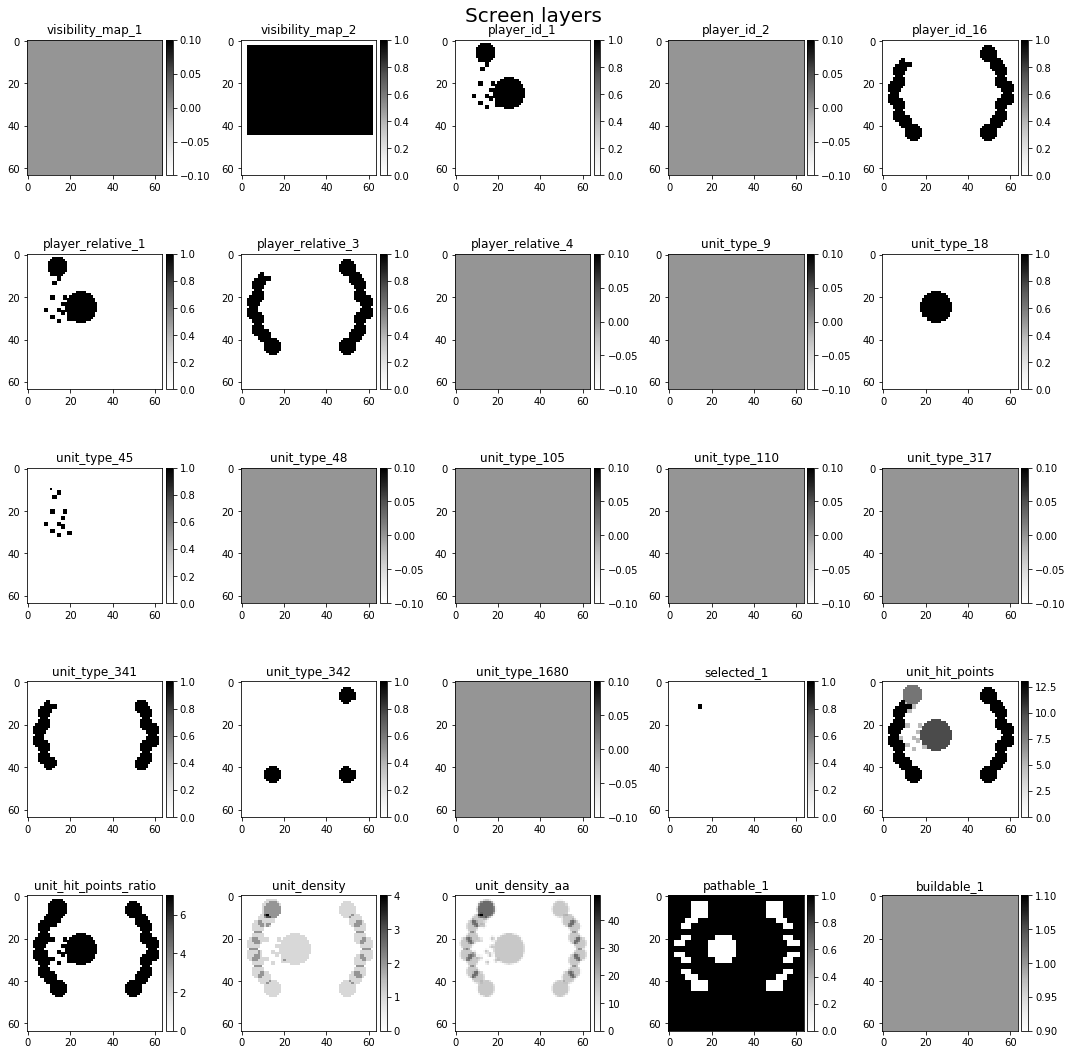

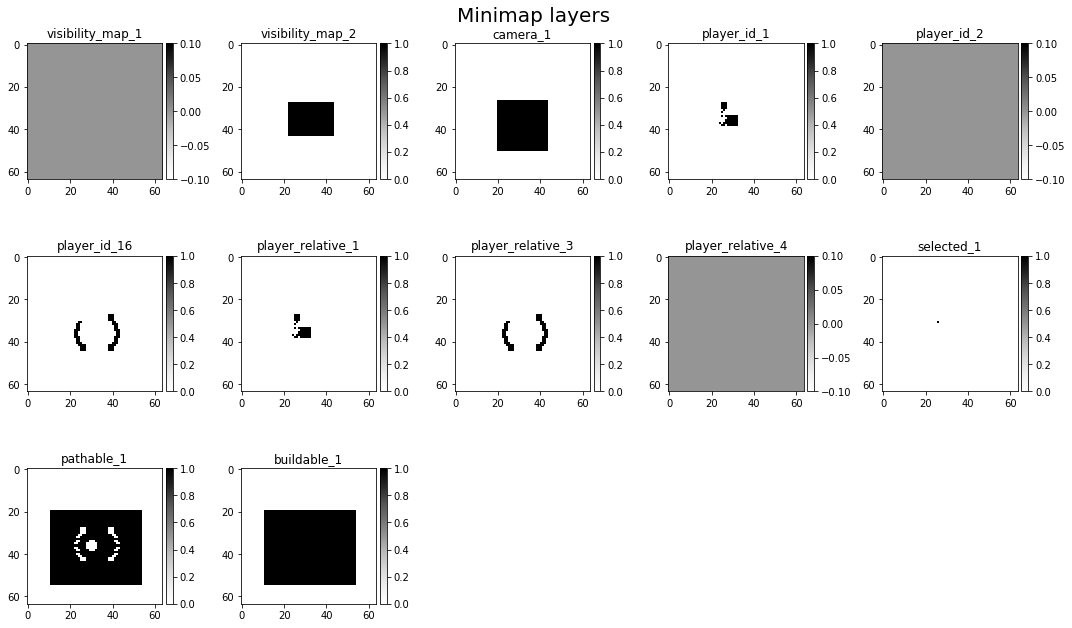

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  15

Player info: 
player_id:  1
minerals:  270
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


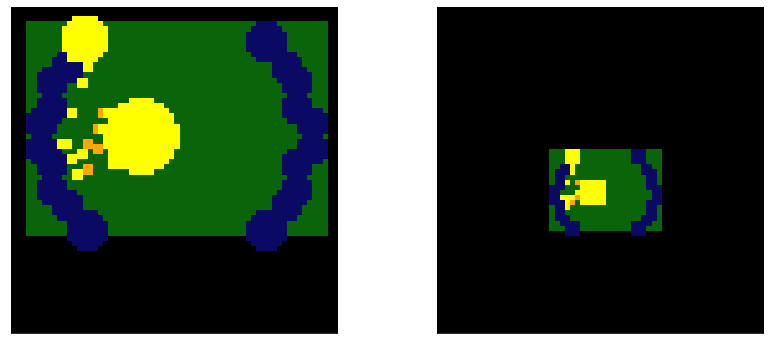

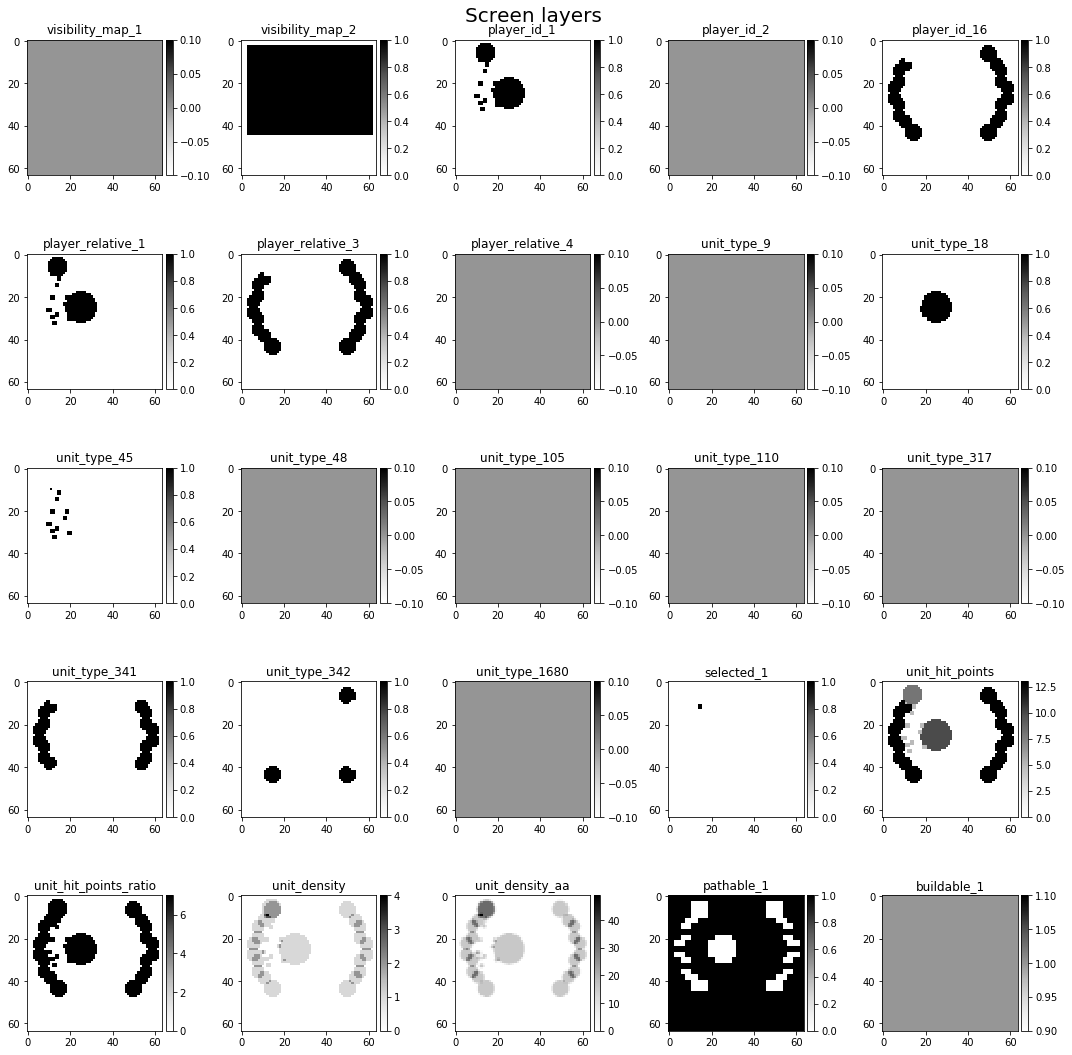

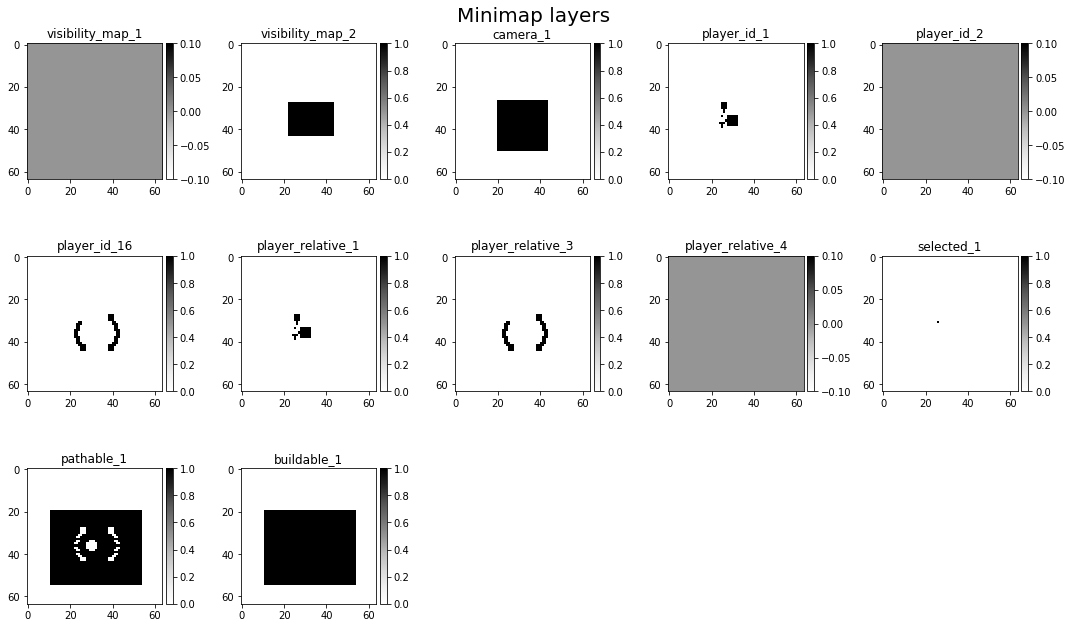

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  270
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


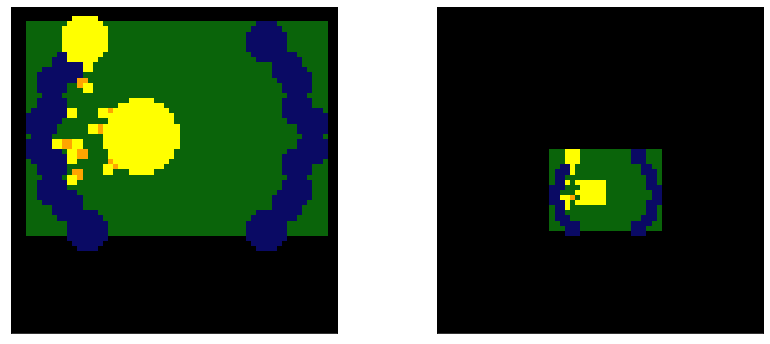

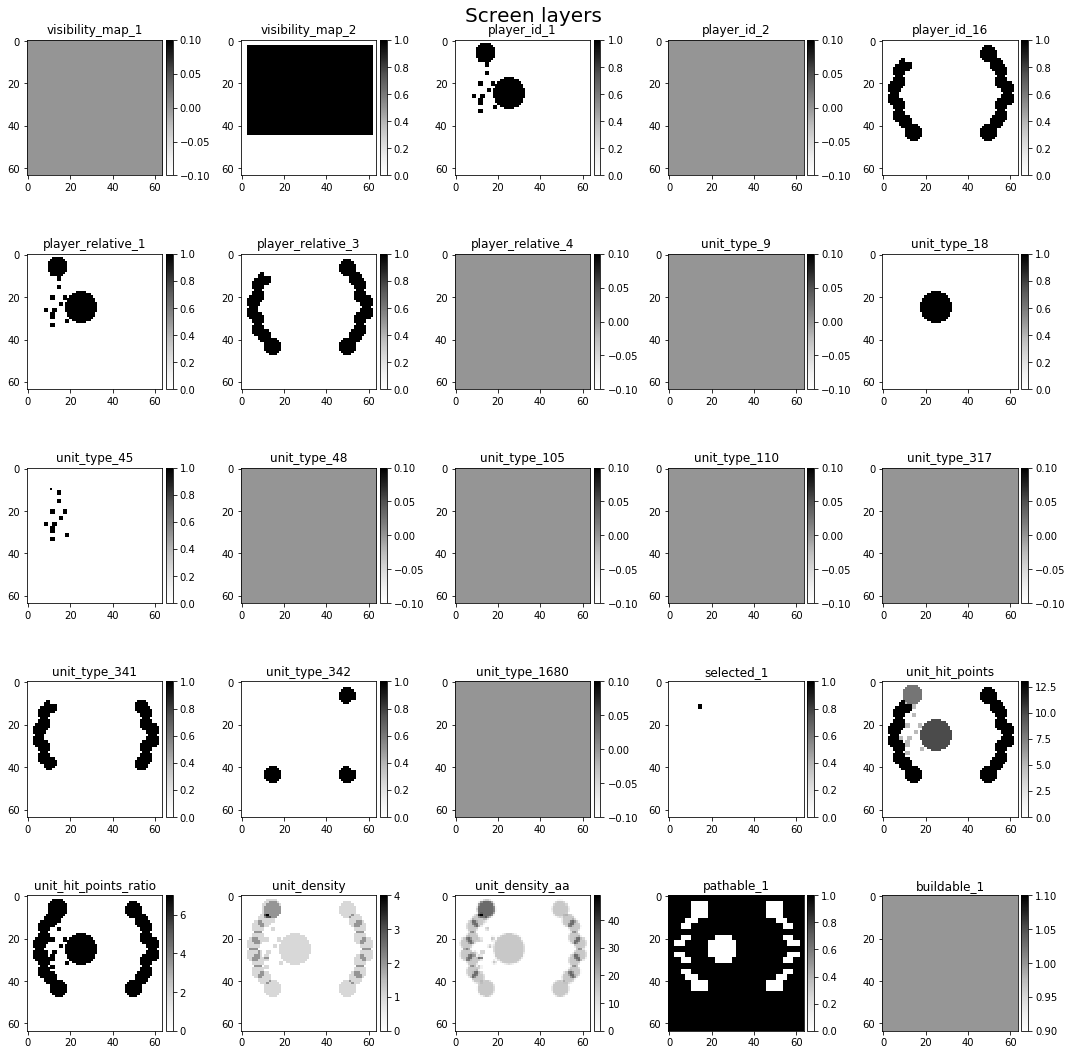

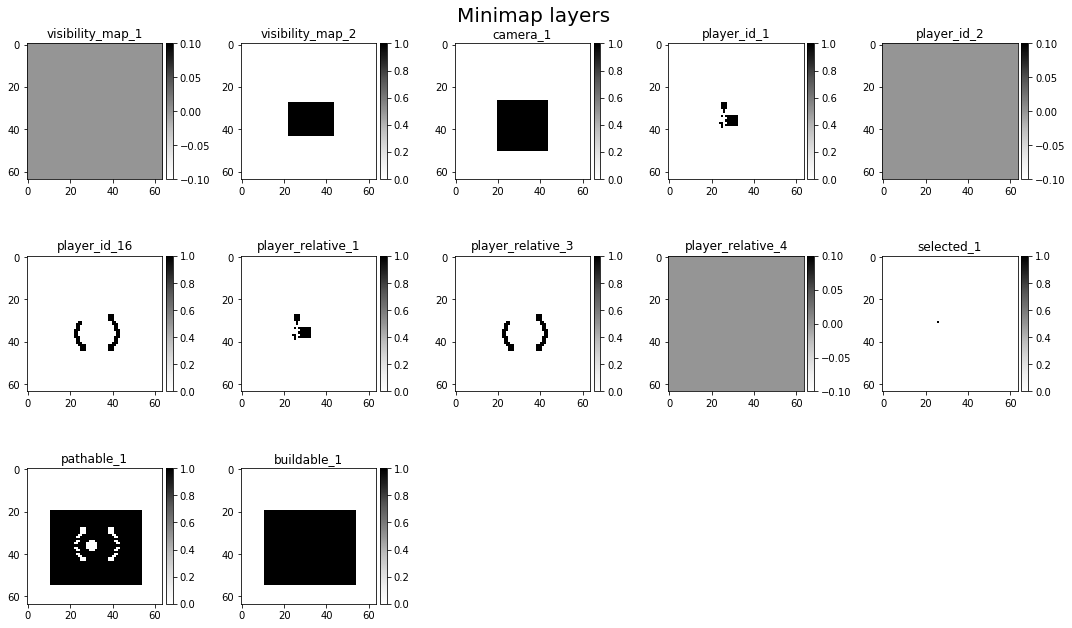

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  270
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


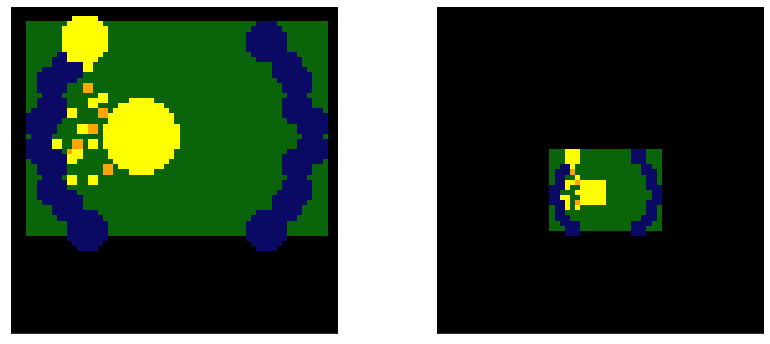

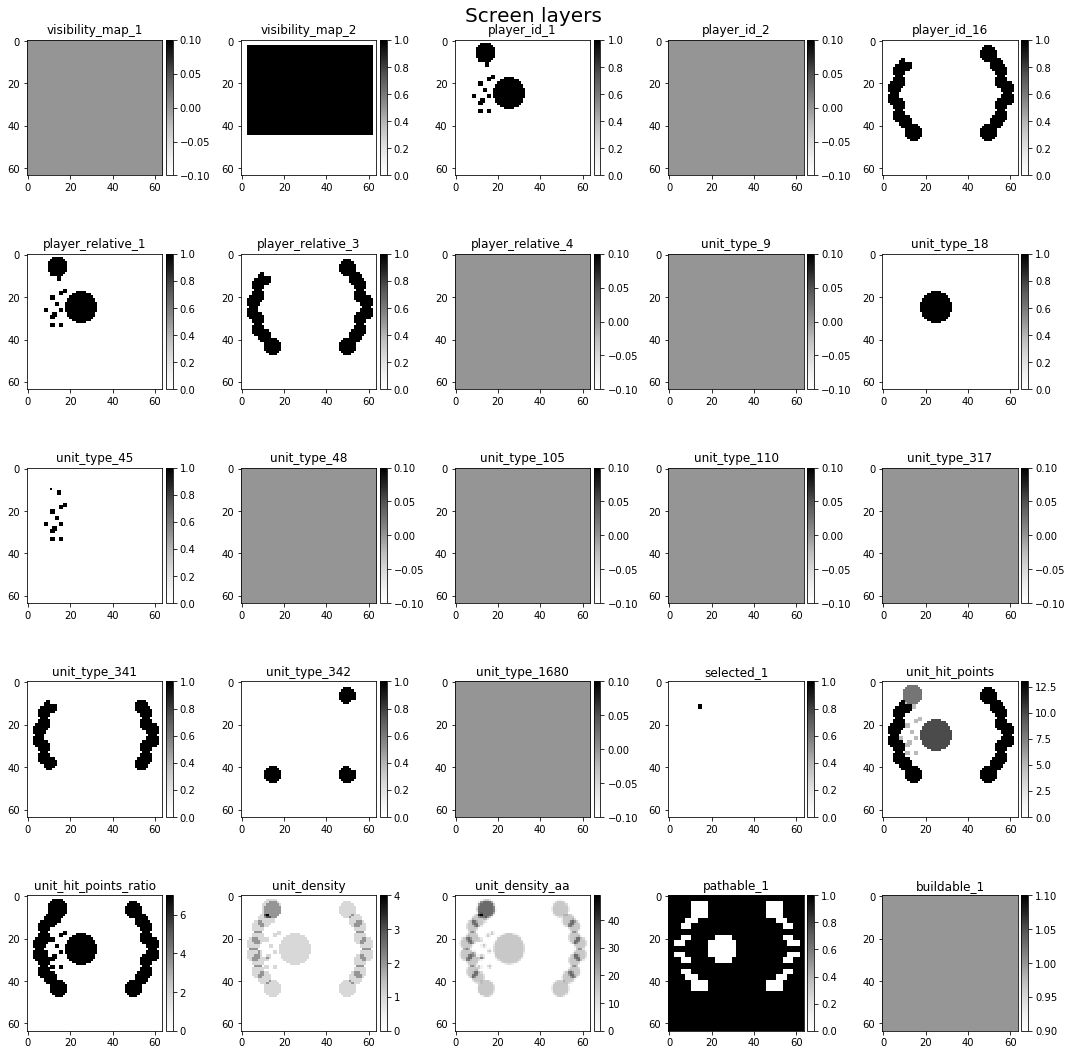

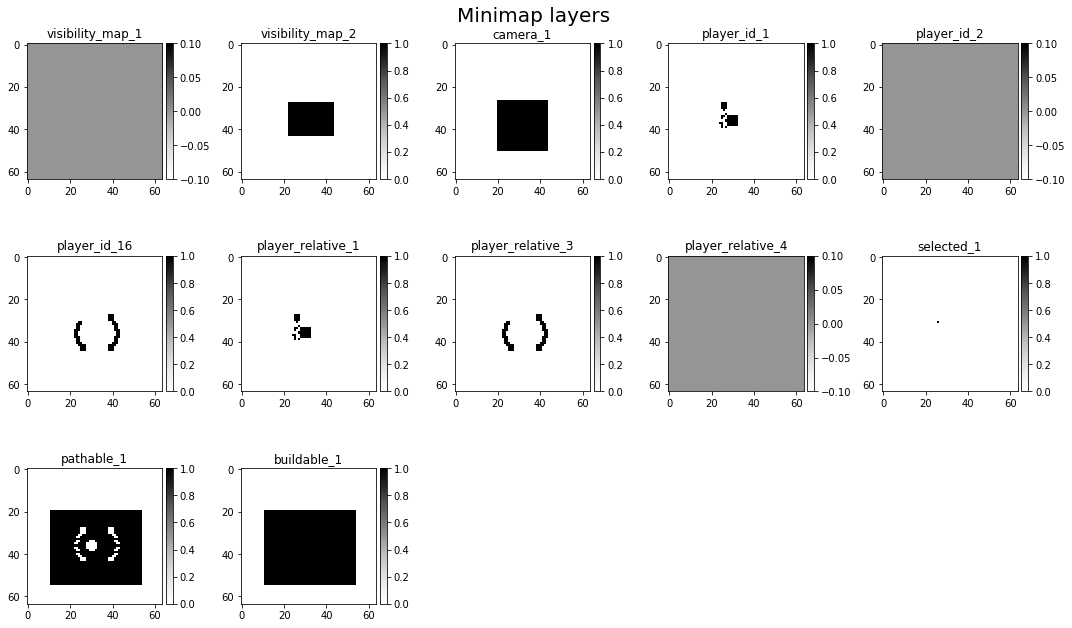

Action taken:  FunctionCall(function=0, arguments=[])
Reward:  0

Player info: 
player_id:  1
minerals:  270
vespene:  0
food_used:  12
food_cap:  15
food_army:  0
food_workers:  12
idle_worker_count:  1
army_count:  0
warp_gate_count:  0
larva_count:  0
Found unexpected value in unit_type layer
Expected possible values: 
 [   9   18   45   48  105  110  317  341  342 1680]
Actual unique values (0 excl.): 
 [ 18  20  45 341 342]


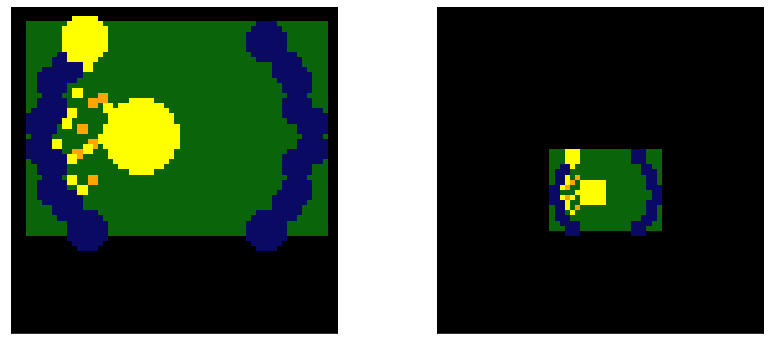

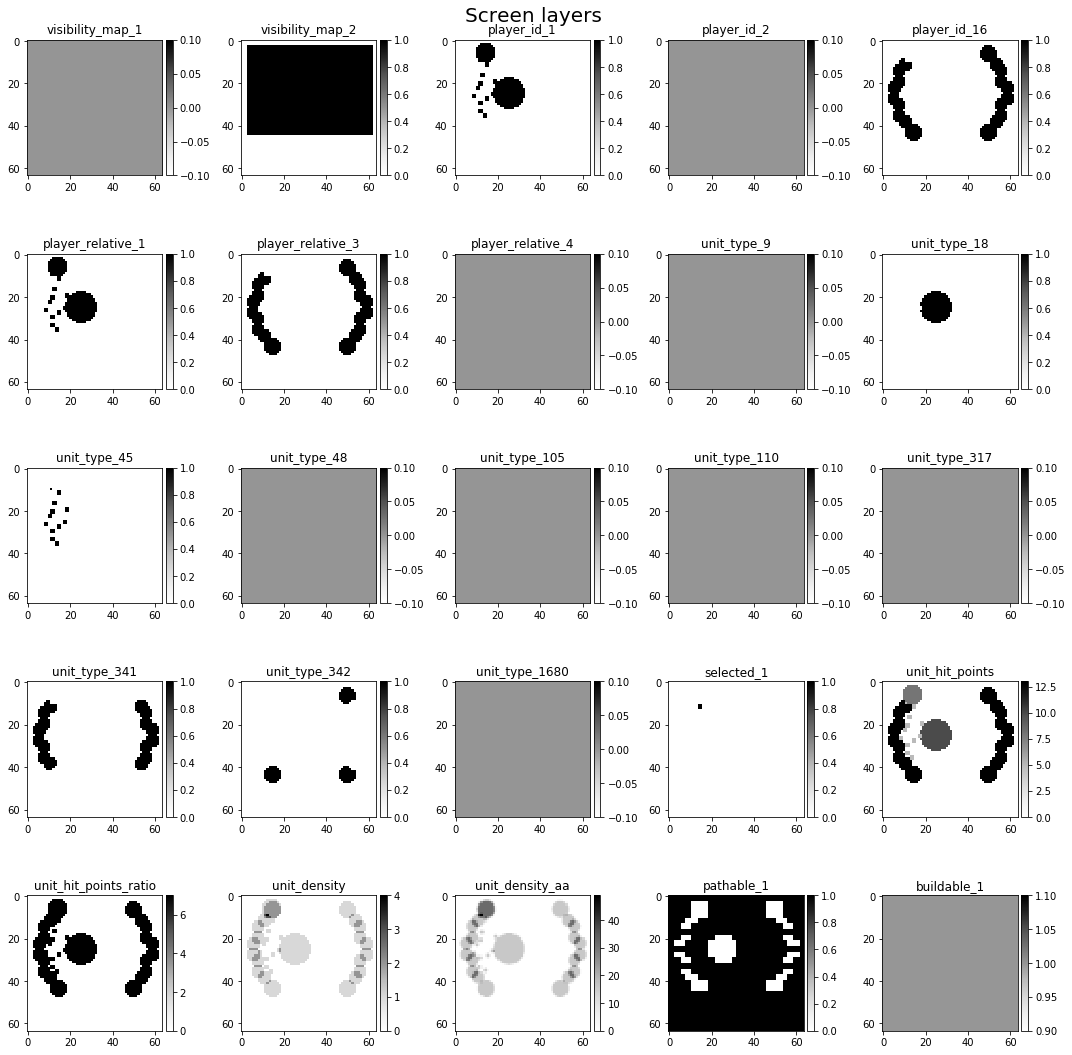

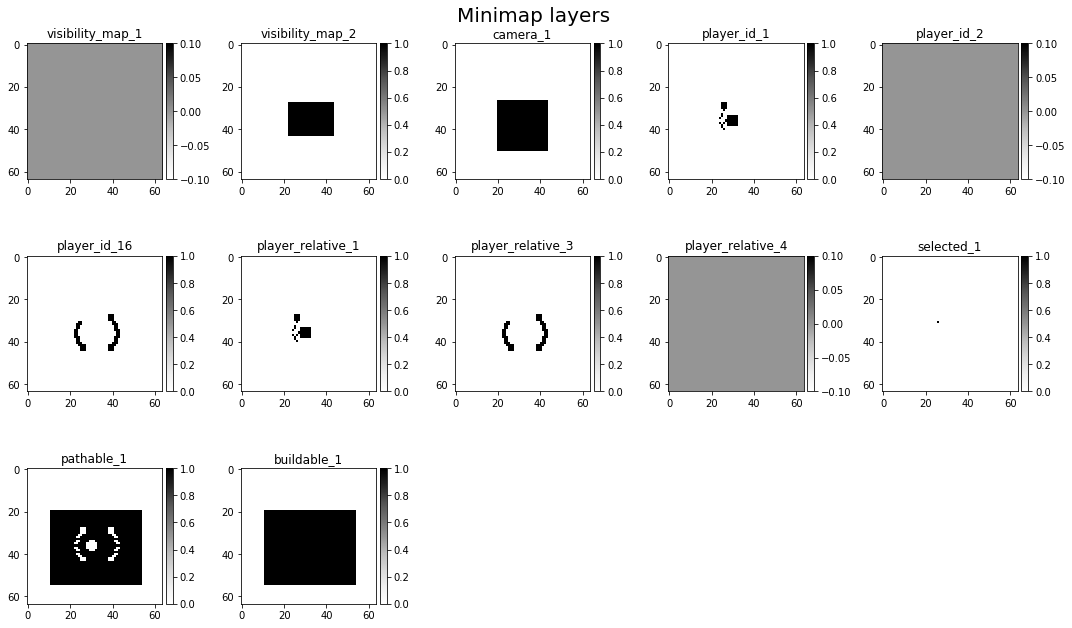

In [37]:
# again wait a bit
for i in range(5):
    #0/no_op ()
    a_id = 0
    a_args = [] 
    a = [sc_actions.FunctionCall(a_id, a_args)]
    #if i != 4:
    #    iplay.interactive_step(a, show_available=False, rendering=False)
    #else:
    #    iplay.interactive_step(a, show_available=False, rendering=True)
    iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=264, arguments=[[0], [25, 25]])
Reward:  10
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 
0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
6/select_idle_worker (10/select_worker [4])
264/Harvest_Gather_screen (3/queued [2]; 0/screen [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
549/Effect_Spray_minimap (3/queued [2]; 1/minimap [0, 0])
50/Build_EngineeringBay_screen (3/queued [2]; 0/screen [0, 0])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2

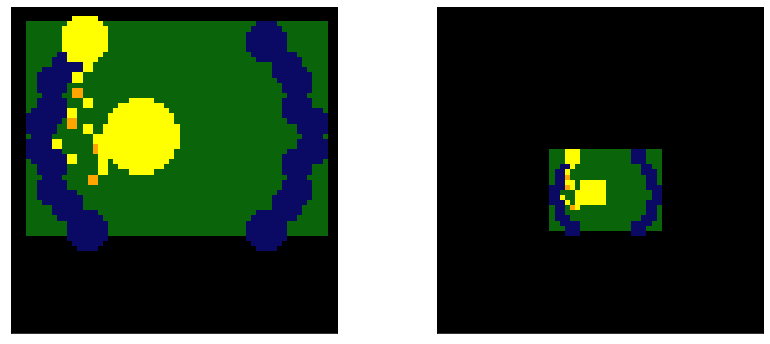

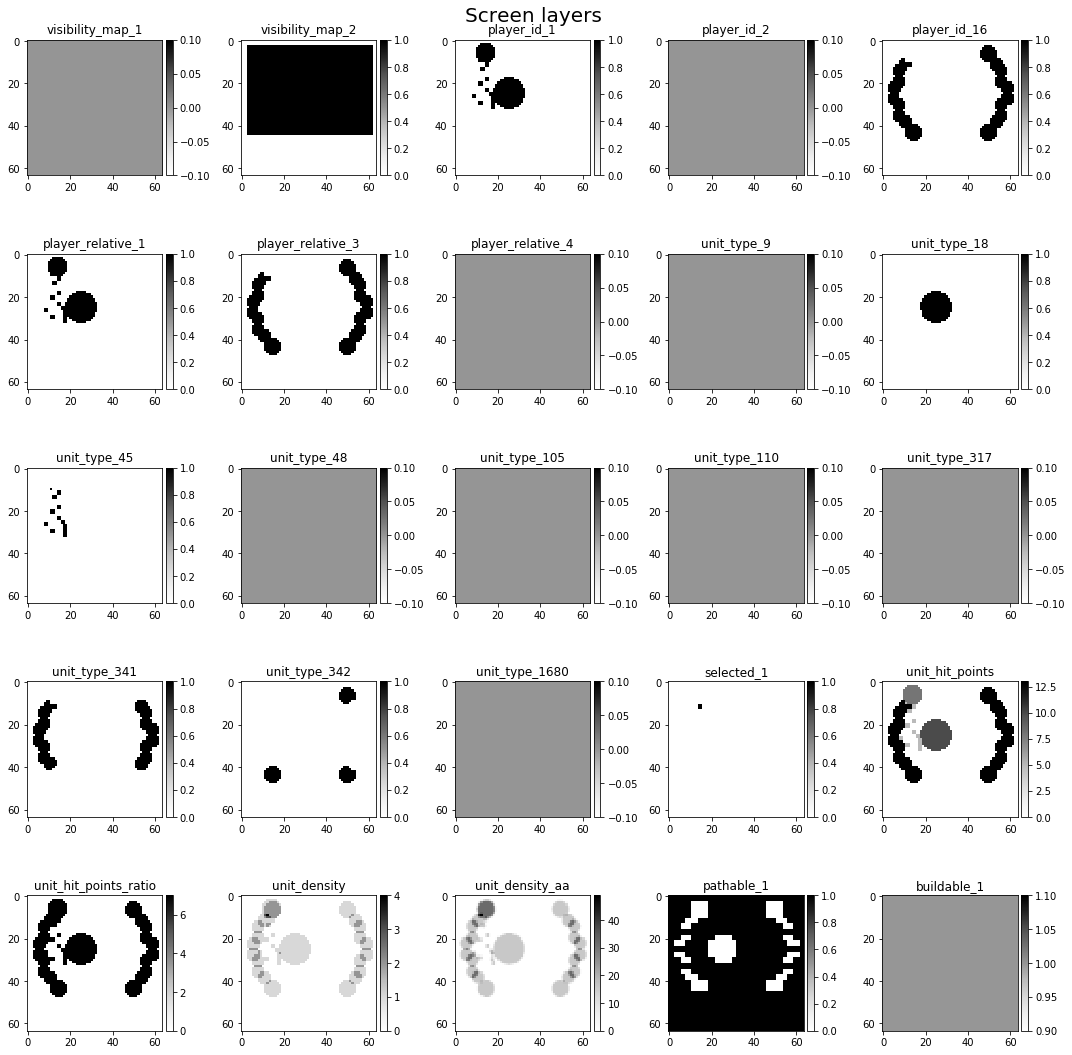

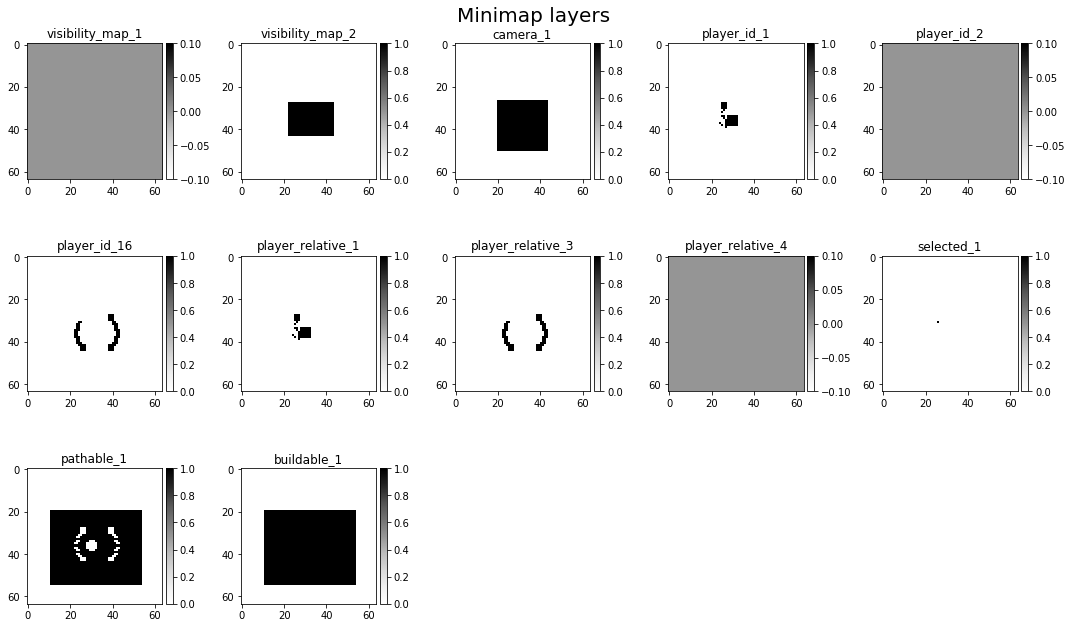

In [36]:
# Let's bring it back to the center and hope it gathered something
# 264/Harvest_Gather_screen
for i in range(1):
    a_id = 264
    a_args = [[0],[25,25]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    iplay.interactive_step(a, show_available=True)

I actually have no idea of what combination of actions one needs to do to collect the gas... 

In [ ]:
# Select command center
# select rectangle: 3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
a_id = 3
a_args = [[0], [25,25],[30,40]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

In [38]:
iplay.close()

# Example - DefeatRoaches / DefeatZerglingAndBanelings

In [13]:
iplay = InteractivePlay(map_name, screen_res, minimap_res, **preproc_args)

Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
7/select_army (7/select_add [2])
Friendly units positions: 
x,y:  27 9
x,y:  27 10
x,y:  27 11
x,y:  27 13
x,y:  27 14
x,y:  27 15
x,y:  27 17
x,y:  27 18
x,y:  27 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


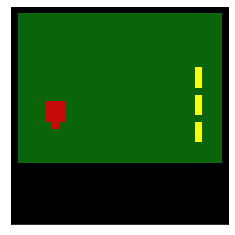

In [14]:
iplay.reset()

Action taken:  FunctionCall(function=7, arguments=[[0]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
453/Stop_quick (3/queued [2])
7/select_army (7/select_add [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
Friendly units po

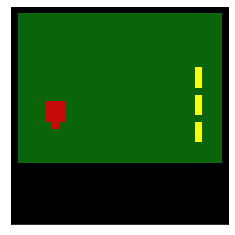

In [15]:
# select_army
a_id = 7
a_args = [[0]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  25 9
x,y:  25 10
x,y:  25 11
x,y:  25 13
x,y:  25 14
x,y:  25 15
x,y:  25 16
x,y:  25 18
x,y:  25 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


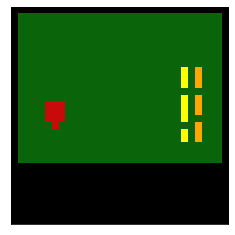

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  24 9
x,y:  24 10
x,y:  24 12
x,y:  24 13
x,y:  24 14
x,y:  24 15
x,y:  24 16
x,y:  24 17
x,y:  24 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


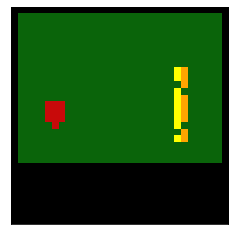

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  22 10
x,y:  22 11
x,y:  22 12
x,y:  22 13
x,y:  22 14
x,y:  22 15
x,y:  22 16
x,y:  22 17
x,y:  22 18
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


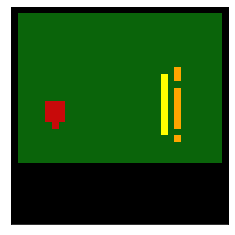

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  21 10
x,y:  21 11
x,y:  21 12
x,y:  21 13
x,y:  21 14
x,y:  21 15
x,y:  21 16
x,y:  21 17
x,y:  21 18
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


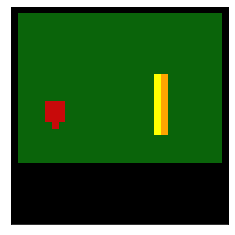

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  19 10
x,y:  19 11
x,y:  19 12
x,y:  19 13
x,y:  19 14
x,y:  19 15
x,y:  19 16
x,y:  19 17
x,y:  19 18
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


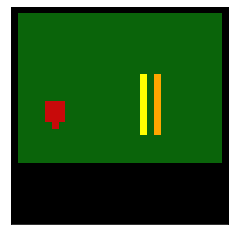

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  18 10
x,y:  18 11
x,y:  18 12
x,y:  18 13
x,y:  18 14
x,y:  18 15
x,y:  18 16
x,y:  18 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


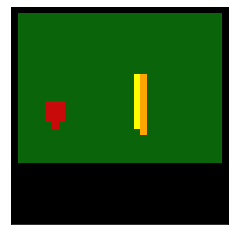

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  16 10
x,y:  16 11
x,y:  16 12
x,y:  17 13
x,y:  16 14
x,y:  17 14
x,y:  16 15
x,y:  16 16
x,y:  16 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


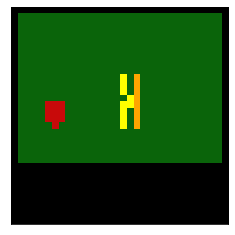

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  15 11
x,y:  15 12
x,y:  15 13
x,y:  16 13
x,y:  15 14
x,y:  15 15
x,y:  15 16
x,y:  15 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  7 14
x,y:  5 15
x,y:  6 15
x,y:  7 15
x,y:  5 16
x,y:  6 16
x,y:  7 16
x,y:  6 17


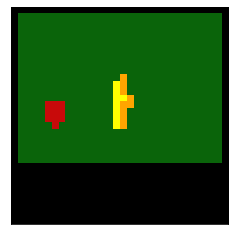

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  14 11
x,y:  14 12
x,y:  13 13
x,y:  14 13
x,y:  13 14
x,y:  14 14
x,y:  13 15
x,y:  14 16
x,y:  14 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  6 14
x,y:  8 14
x,y:  5 15
x,y:  7 15
x,y:  9 15
x,y:  5 16
x,y:  7 16
x,y:  9 16
x,y:  7 17


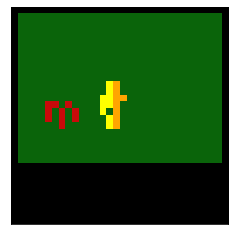

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  5
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  13 13
x,y:  14 13
x,y:  13 14
x,y:  14 14
x,y:  13 15
x,y:  13 16
x,y:  13 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  8 14
x,y:  10 14
x,y:  11 14
x,y:  7 15
x,y:  9 15
x,y:  6 16
x,y:  9 16
x,y:  11 16
x,y:  8 17


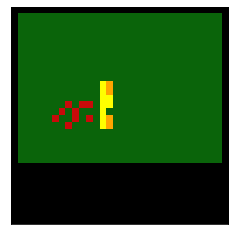

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  13 13
x,y:  14 13
x,y:  13 14
x,y:  14 14
x,y:  13 15
x,y:  13 16
x,y:  13 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  11 13
x,y:  10 14
x,y:  12 14
x,y:  9 15
x,y:  11 15
x,y:  8 16
x,y:  10 16
x,y:  12 16
x,y:  10 17


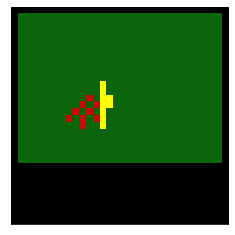

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  10
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  13 13
x,y:  14 13
x,y:  13 14
x,y:  14 14
x,y:  13 15
x,y:  13 16
x,y:  13 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  11 14
x,y:  12 14
x,y:  12 15
x,y:  11 16
x,y:  12 16
x,y:  10 17
x,y:  11 17


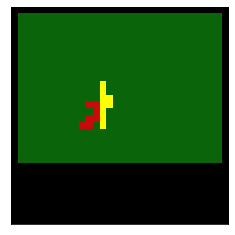

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  1
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  13 13
x,y:  14 13
x,y:  14 14
Neutral units positions:  [] []
Enemy units positions: 
x,y:  12 13
x,y:  11 14
x,y:  12 14
x,y:  12 15
x,y:  11 16
x,y:  12 16


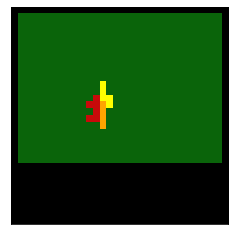

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  4
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  14 13
x,y:  14 14
Neutral units positions:  [] []
Enemy units positions: 
x,y:  11 12
x,y:  12 13
x,y:  13 14
x,y:  11 15
x,y:  12 16


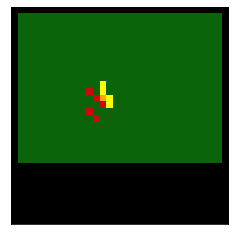

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  14 13
x,y:  14 14
Neutral units positions:  [] []
Enemy units positions: 
x,y:  12 11
x,y:  12 13
x,y:  13 14
x,y:  13 15
x,y:  14 15


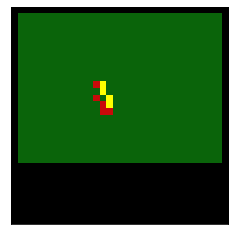

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  -1
Friendly units positions: 
x,y:  13 11
x,y:  13 12
x,y:  14 13
Neutral units positions:  [] []
Enemy units positions: 
x,y:  12 11
x,y:  12 13
x,y:  13 14
x,y:  13 15
x,y:  14 15


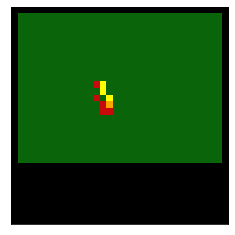

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  -2
Friendly units positions: 
x,y:  14 13
Neutral units positions:  [] []
Enemy units positions: 
x,y:  12 11
x,y:  12 13
x,y:  12 14
x,y:  13 14
x,y:  14 14


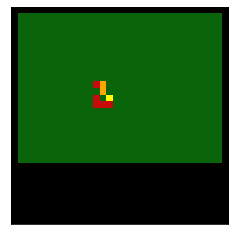

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  -1
Friendly units positions: 
Neutral units positions:  [] []
Enemy units positions: 
x,y:  11 11
x,y:  11 13
x,y:  12 13
x,y:  13 14
x,y:  14 14


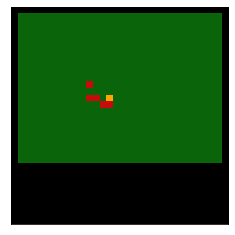

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])
Reward:  0.0
Friendly units positions: 
x,y:  4 9
x,y:  4 10
x,y:  4 11
x,y:  4 13
x,y:  4 14
x,y:  4 15
x,y:  4 17
x,y:  4 18
x,y:  4 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  23 11
x,y:  24 11
x,y:  25 11
x,y:  23 12
x,y:  24 12
x,y:  25 12
x,y:  23 13
x,y:  24 13
x,y:  25 13
x,y:  24 14


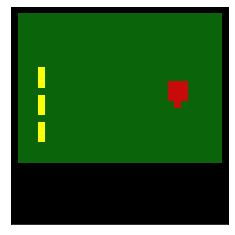

Action taken:  FunctionCall(function=12, arguments=[[0], [5, 15]])


ValueError: Function 12/Attack_screen is currently not available

In [16]:
# Attack_screen
for _ in range(20):
    a_id = 12
    a_args = [[0],[5,15]]
    a = [sc_actions.FunctionCall(a_id, a_args)]
    iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=331, arguments=[[0], [25, 15]])
Reward:  0
Friendly units positions: 
x,y:  15 11
x,y:  15 12
x,y:  15 13
x,y:  15 14
x,y:  16 14
x,y:  15 15
x,y:  15 16
x,y:  15 17
Neutral units positions:  [] []
Enemy units positions: 
x,y:  5 14
x,y:  8 14
x,y:  10 14
x,y:  11 14
x,y:  5 15
x,y:  9 15
x,y:  11 15
x,y:  5 16
x,y:  9 16
x,y:  8 17


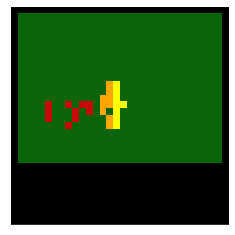

In [161]:
# Move_screen (backwards)
a_id = 331
a_args = [[0],[25,15]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=274, arguments=[[0]])
Reward:  0.0
Friendly units positions: 
x,y:  4 9
x,y:  4 10
x,y:  4 11
x,y:  4 13
x,y:  4 14
x,y:  4 15
x,y:  4 17
x,y:  4 18
x,y:  4 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  23 11
x,y:  24 11
x,y:  25 11
x,y:  23 12
x,y:  24 12
x,y:  25 12
x,y:  23 13
x,y:  24 13
x,y:  25 13
x,y:  24 14


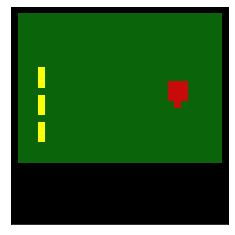

In [169]:
# HoldPosition_quick
a_id = 274
a_args = [[0]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=False)

In [21]:
iplay.close()

## Example 1 - Control group actions
Action: 4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])

control_group_act meanings:
- recall, set, append, set_and_steal, append_and_steal

So probably to create a control group you first select maunally the units and then you play select_control_group([[ set ], [ 0 ]]) to assign the selected unit to control group 0. **Verified in the example above.**

Question: how is it possible to recognize which unit is inside which control group? 

In [18]:
iplay = InteractivePlay(map_name, screen_res, minimap_res, **preproc_args)

Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
7/select_army (7/select_add [2])
Friendly units positions: 
x,y:  27 9
x,y:  27 10
x,y:  27 11
x,y:  27 13
x,y:  27 14
x,y:  27 15
x,y:  27 17
x,y:  27 18
x,y:  27 19
Neutral units positions:  [] []
Enemy units positions: 
x,y:  6 13
x,y:  6 14
x,y:  6 16
x,y:  6 17


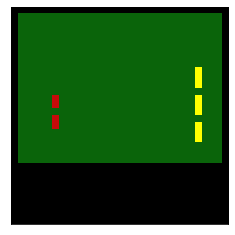

In [19]:
iplay.reset()

Action taken:  FunctionCall(function=7, arguments=[[0]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
453/Stop_quick (3/queued [2])
7/select_army (7/select_add [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
Friendly units po

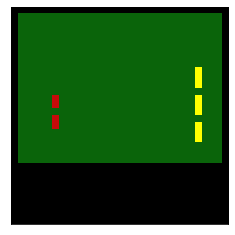

In [20]:
a_id = 3
a_args = [[0],[12,4],[16,6]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=4, arguments=[[1], [0]])
Reward:  0
Friendly units positions: 
x,y:  14 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


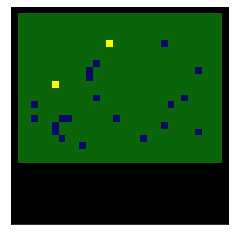

In [42]:
# select_control_group - set new control group
a_id = 4
a_args = [[1],[0]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [23, 5]])
Reward:  0
Friendly units positions: 
x,y:  16 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


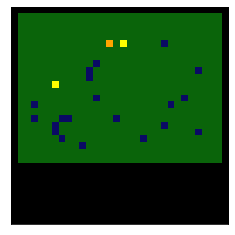

In [43]:
a = actions.move(point=[23,5]) # xfirst
iplay.interactive_step(a)

Action taken:  FunctionCall(function=3, arguments=[[0], [5, 10], [7, 12]])
Reward:  0
Control groups:  [[48  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]]
Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
453/Stop_quick (3/queued [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
7/select_army (7/select_add [2])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
Friendly units positions: 
x,y:  17 5
x,y

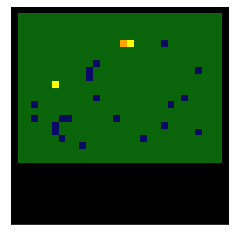

In [44]:
# use select rectangle to select the other unit
a_id = 3
a_args = [[0],[5,10],[7,12]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=4, arguments=[[1], [1]])
Reward:  0
Friendly units positions: 
x,y:  19 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


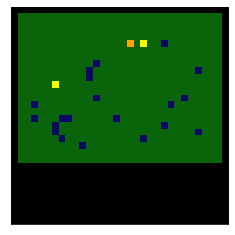

In [45]:
# select_control_group - set new control group
a_id = 4
a_args = [[1],[1]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [3, 12]])
Reward:  0
Friendly units positions: 
x,y:  20 5
x,y:  5 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


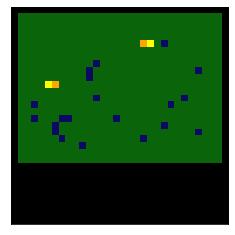

In [46]:
a = actions.move([3,12]) # xfirst
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=4, arguments=[[0], [0]])
Reward:  1
Friendly units positions: 
x,y:  22 5
x,y:  4 12
Neutral units positions:  [12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


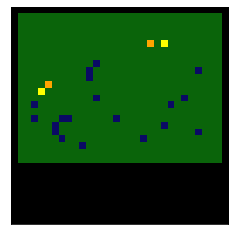

In [47]:
# Now we select once again the first unit
# select_control_group - set new control group
a_id = 4
a_args = [[0],[0]] #(select, group 0)
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [27, 10]])
Reward:  0
Friendly units positions: 
x,y:  23 6
x,y:  3 12
Neutral units positions:  [12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


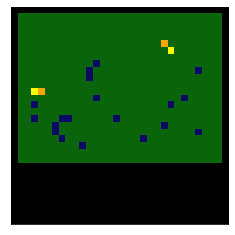

In [48]:
a = actions.move([27,10]) # xfirst
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=<_Functions.no_op: 0>, arguments=[])
Reward:  1
Friendly units positions: 
x,y:  26 9
x,y:  3 12
Neutral units positions:  [12 11 11 12 25 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9 10 13 13 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


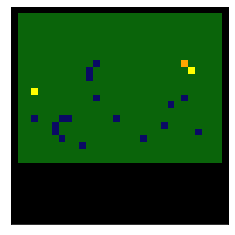

In [51]:
a = actions.no_op()
iplay.interactive_step(a)

It seems that unlike in real game, trying to select a point or rectangle that does not contain units doesn't deselect the current unit. So basically with this action space and a single unit, you have to select your unit once and it will remain selected untill the end of the episode.

In [21]:
iplay.close()

In [ ]:
# Other possible actions

In [ ]:
a_id = 3
a_args = [[0],[12,4],[16,6]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

In [ ]:
a = actions.select()
iplay.interactive_step(a, show_available=False)

In [ ]:
p = yx_points_dict['lower-center']
print(p[1])
a = actions.move([p[1],p[0]]) # xfirst
print(a)
iplay.interactive_step(a, show_available=False)

Actions checked:
- 0/no_op ()
- 2/select_point (6/select_point_act [4]; 0/screen [0, 0])
- 3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
- 4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
- 7/select_army (7/select_add [2])
- 12/Attack_screen (3/queued [2]; 0/screen [0, 0])


Other actions to check:
- 1/move_camera (1/minimap [0, 0]) - shows on the screen the part of the minimap in which it has clicked
- 453/Stop_quick (3/queued [2]) - stops the unit in place
- 451/Smart_screen (3/queued [2]; 0/screen [0, 0]) - no idea
- 452/Smart_minimap (3/queued [2]; 1/minimap [0, 0]) - no idea
- 331/Move_screen (3/queued [2]; 0/screen [0, 0]) - moves selected unit on that point of the screen
- 332/Move_minimap (3/queued [2]; 1/minimap [0, 0]) - moves selected unit on that point of the minimap
- 333/Patrol_screen (3/queued [2]; 0/screen [0, 0]) - goes back and forth from the current position and the one that has clicked on the screen
- 334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0]) - goes back and forth from the current position and the one that has clicked on the minimap
- 13/Attack_minimap (3/queued [2]; 1/minimap [0, 0]) - moves selected unit on that point of the minimap while engaging in combat
- 274/HoldPosition_quick (3/queued [2]) - forces unit to hold position (instead of going automatically against enemy troops?)

So either we try to get the action space as big as possible or we enlarge it just enough to contain optimal strategies.

**Optimal strategies**:
- micromanagement of units (e.g. in CollectMineralShards the gathering of shards is immediate, so to have the two agents in 2 different places going after 2 different shards should be better) -> granular selection (can be done with select point and select rectangle, onestly between the 2 I would use the rectangle because it's easier)



In [9]:
# Objective: create list of action ids that we want to use in the game

# Ex1: no_op, select_army, attack_screen, Move_screen
_NO_OP = sc_actions.FUNCTIONS['no_op'].id
_SELECT_ARMY = sc_actions.FUNCTIONS['select_army'].id
_ATTACK_SCREEN = sc_actions.FUNCTIONS['Attack_screen'].id
_MOVE_SCREEN = sc_actions.FUNCTIONS['Move_screen'].id

In [11]:
action_names = ['no_op', 'select_army', 'Attack_screen', 'Move_screen']

In [12]:
action_ids = [sc_actions.FUNCTIONS[a_name].id for a_name in action_names]
action_ids

[<_Functions.no_op: 0>,
 <_Functions.select_army: 7>,
 <_Functions.Attack_screen: 12>,
 <_Functions.Move_screen: 331>]

In [16]:
# this needs to be passed both to each worker to compute get_action_mask() func and to SpatialActorCritic
action_dict = {i:action_ids[i] for i in range(len(action_ids))}
type(action_dict)

dict